In [2]:
from keras.layers import Input, Dense, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, LeakyReLU, Flatten, MaxPool2D 
from keras.models import Model
import keras.backend as K

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Author: Jose Sepulveda
# Description: This is a keras implementation of spectral normalization.
#              This was proposed in this paper: https://arxiv.org/pdf/1802.05957.pdf
#


from keras import backend as K


# Stochastic Gradient Descent with Spectral Normalization:
#   1) Initialize a random vector u, initialized from an isotropic distribution.
#   2) Use the Power iteration method with this vector u on the matrix of wieghts
#      to obtain two approximations of eigenvectors.
#   3) Calculate the spectral norm of the wieghts matrix.
#   4) Update wieghts using vanilla SGD using the spectral norm of the wieghts matrix.

def spectral_norm(w):
    """
        Input: tensor of wieghts
        Output: SN tensor of wieghts
    """
    def l2_norm(v):
        return K.sum(v ** 2) ** 0.5

    w_dim = w.shape.as_list()[-1]
    # Initialize random vector u
    u = K.random_normal(shape=[1, w_dim])

    # We need to flatten the wieghts
    w_flat = K.reshape(w, [-1, w_dim])

    # Power iteration method
    v = K.dot(u, K.transpose(w_flat))
    v = v / l2_norm(v)
    u = K.dot(v, w_flat)
    u = u / l2_norm(u)

    # Calculate the SN of W
    sigma = K.dot(K.dot(v, w_flat), K.transpose(u))
    w_sn = w_flat / sigma

    # Update wieghts
    w_sn = K.reshape(w_sn, w.shape.as_list())
    return w_sn


In [4]:
def ResBlockDown(input_shape, channel_size, channel_multiplier=1, name=None):
    # Resblock architecture
    # 1 BatchNorm 
    # 2 ReLU activation
    # 3 Conv layer
    # 4 BatchNorm
    # 5 ReLU activation
    # 6 Conv layer
    # 7 Sum with input 
    
    #FIRST BLOCK
    #input layer
    input_layer = Input(shape=input_shape)
    
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(input_layer)
    
    # Relu
    resblock = Activation('relu')(resblock)
    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same', strides=2)(resblock)
    #SECOND BLOCK
    
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(resblock)
    # Relu
    resblock = Activation('relu')(resblock)
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same')(resblock)
    # Downsample
    #resblock = AveragePooling2D()(resblock)
    
    # Time for the shortcut connection!
    
    shortcut_identity = Conv2D(channel_size * channel_multiplier, 3, padding='same', strides=2)(input_layer)
    #shortcut_identity = AveragePooling2D()(shortcut_identity)
    
    output_layer = Add()([shortcut_identity, resblock])
    
    return Model(input_layer, output_layer, name=name)
    





In [5]:
def ResBlockUp(input_shape, channel_size, channel_multiplier=1, name=None):
    # Resblock architecture
    # 1 BatchNorm 
    # 2 ReLU activation
    # 3 Conv layer
    # 4 BatchNorm
    # 5 ReLU activation
    # 6 Conv layer
    # 7 Sum with input 
    
    #FIRST BLOCK
    #input layer
    input_layer = Input(shape=input_shape)
    
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(input_layer)
    
    # Relu
    resblock = Activation('relu')(resblock)
    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2DTranspose(channel_size * channel_multiplier, 3, padding='same', strides=2)(resblock)
    
    #SECOND BLOCK
    
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(resblock)
    
    # Relu
    resblock = Activation('relu')(resblock)
    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2DTranspose(channel_size * channel_multiplier, 3, padding='same')(resblock)
    
    # Downsample
    #resblock = AveragePooling2D()(resblock)
    
    # Time for the shortcut connection!
    
    shortcut_identity = Conv2DTranspose(channel_size * channel_multiplier, 1, padding='same', strides=2)(input_layer)
    #shortcut_identity = AveragePooling2D()(shortcut_identity)
    output_layer = Add()([shortcut_identity, resblock])
    
    return Model(input_layer, output_layer, name=name)
    
    

In [6]:
def ResBlock(input_shape, channel_size, channel_multiplier=1, name=None):
     # Resblock architecture
    # 1 BatchNorm 
    # 2 ReLU activation
    # 3 Conv layer
    # 4 BatchNorm
    # 5 ReLU activation
    # 6 Conv layer
    # 7 Sum with input 
    
    #FIRST BLOCK
    #input layer
    input_layer = Input(shape=input_shape)
    
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(input_layer) 
    # Relu
    resblock = Activation('relu')(resblock)
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same')(resblock)
    
    #SECOND BLOCK   
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(input_layer)    
    # Relu
    resblock = Activation('relu')(resblock)    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same')(resblock)
     
    # Time for the shortcut connection!   
    shortcut_identity = Conv2D(channel_size * channel_multiplier, 1, padding='same')(input_layer)
    output_layer = Add()([shortcut_identity, resblock])
    
    return Model(input_layer, output_layer, name=name)
    
    
    
    
    
    

In [7]:


def SelfAttentionBlock(input_shape, name=None):
    # f = conv
    channels = input_shape[-1]
    input_layer = Input(shape=input_shape)
    f = Conv2D(channels // 8, 1, padding='same')(input_layer)
    # f = maxpooling
    f = MaxPool2D(pool_size=2, strides=2, padding='same')(f)
    
    g = Conv2D(channels // 8, 1, padding='same')(input_layer)
    
    h = Conv2D(channels // 2, 1, padding='same')(input_layer)
    h = MaxPool2D(pool_size=2, strides=2, padding='same')(h)
    
    
    g = Lambda(lambda input1: K.reshape(input1, shape=[-1,1]))(g)
    f = Lambda(lambda input1: K.reshape(input1, shape=[-1,1]))(f)
    s = Dot(-1)([g, f])
    beta = Activation('softmax')(s)

    h = Lambda(lambda input1: K.reshape(input1, shape=[-1,1]))(h)
    o = Dot(-1)([beta, h])
    
    gamma = Conv2D(channels, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(input_layer)
    #gamma = Reshape((-1, channels // 2))(g)
    #print(gamma.shape)
    a, x, y ,z = input_layer.shape
    #o = K.reshape(o, shape=[x,y,z, channels // 2])
    o = Lambda(lambda input1: K.reshape(input1, shape=[x,y,z, channels // 2]))(o)
    o = Conv2D(channels, kernel_size=1, strides=1)(o)
  
    Wz_yi = Multiply()([gamma, o])
    output_layer = Add()([Wz_yi, input_layer])
    #output_layer = gamma*o + input_layer
    
    return Model(input_layer, output_layer, name=name)

In [8]:

def GlobalSumPooling2D(name=None):
    return Lambda(lambda inputs: K.sum(inputs, axis=[1, 2]), name=name)
        
# Discriminator test
def build_discriminator(channel_multiplier=32):
    model_input = Input(shape=(64,64,3), name="D_input")
    resblockdown1 = ResBlockDown(input_shape=(32,32,3),channel_size=1, channel_multiplier=channel_multiplier, name='D_resblock_down_1')
    h = resblockdown1(model_input)
    selfattentionblock = SelfAttentionBlock(input_shape=(64,64,32), name='D_self_attention_block')
    h = selfattentionblock(h)
    # Non local block should be here
    resblockdown2 = ResBlockDown(input_shape=(32,32,32),channel_size=2, channel_multiplier=channel_multiplier, name='D_resblock_down_2')
    h = resblockdown2(h)
    #print(h.shape)
    resblockdown4 = ResBlockDown(input_shape=(16,16,64),channel_size=4, channel_multiplier=channel_multiplier, name='D_resblock_down_4')
    h = resblockdown4(h)
    #print(h.shape)
    resblockdown8 = ResBlockDown(input_shape=(8,8,128),channel_size=8, channel_multiplier=channel_multiplier, name='D_resblock_down_8')
    h = resblockdown8(h)
    #print(h.shape)
    resblockdown16 = ResBlockDown(input_shape=(4,4,256),channel_size=16, channel_multiplier=channel_multiplier, name='D_resblock_down_16')
    h = resblockdown16(h)
    #print(h.shape)
    resblock16 = ResBlock(input_shape=(2,2,512),channel_size=16, channel_multiplier=channel_multiplier, name='D_resblock_16')
    h = resblock16(h)
    #print(h.shape)
    h = Activation('relu', name="D_relu")(h)
    h = GlobalSumPooling2D(name="D_global_sum_pooling_2D")(h)
    model_output = Dense(1, name="D_dense")(h)
    model = Model(model_input, model_output, name="Discriminator")
    return model
build_discriminator().summary()


ValueError: Operands could not be broadcast together with shapes (64, 64, 32) (64, 32, 32)

In [53]:
# only noise, non conditional
def build_generator(channel_multiplier=64):
    model_input = Input(shape=(128,128), name="G_input")
    h = Dense(4*4*16*channel_multiplier, name="G_dense")(model_input)
    print(h.shape)
    h = Reshape((4,4,16*channel_multiplier))(h) # 512 = 16*ch
    #print(h.shape)
    resblockup16 = ResBlockUp(input_shape=(4,4,512), channel_size=16, channel_multiplier=channel_multiplier, name="G_resblock_up_16")
    h = resblockup16(h)
    #print(h.shape)
    resblockup8 = ResBlockUp(input_shape=(8,8,512), channel_size=8, channel_multiplier=channel_multiplier, name="G_resblock_up_8")
    h = resblockup8(h)
    #print(h.shape)
    resblockup4 = ResBlockUp(input_shape=(16,16,256), channel_size=4, channel_multiplier=channel_multiplier, name="G_resblock_up_4")
    h = resblockup4(h)
    resblockup2 = ResBlockUp(input_shape=(32,32,128), channel_size=2, channel_multiplier=channel_multiplier, name="G_resblock_up_2")
    h = resblockup2(h)
    #print(h.shape)
#     need to debug the following
    #selfattentionblock = SelfAttentionBlock(input_shape=(64,64,32), name='G_self_attention_block')
    #h = selfattentionblock(h)
    #resblockup1 = ResBlockUp(input_shape=(64,64,64), channel_size=1, channel_multiplier=channel_multiplier, name="G_resblock_up_1")
    #h = resblockup1(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    model_output = Conv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh', kernel_regularizer=spectral_norm)(h)
    
    return Model(model_input, model_output, name="Generator")
build_generator().summary()

(?, 128, 256)


ValueError: total size of new array must be unchanged

In [69]:
import glob
import cv2
import numpy as np
def dataLoader(datapath):
    edge_filepaths = sorted(glob.glob(datapath+'edge-*.png'))
    img_filepaths = sorted(glob.glob(datapath+'*.png'))
    edges = []
    imgs = []
    for edge_fp, img_fp in zip(edge_filepaths,img_filepaths):
        edge = cv2.imread(edge_fp, 0)
        img = cv2.imread(img_fp)
        edge[edge != 255] = 0
        edge = edge // 255
        edges.append(edge)
        imgs.append(img)
        
    return np.array(edges), np.array(imgs)
    

In [113]:
edges, imgs = dataLoader('./edge-data/')
print(edges.shape)

(1000, 64, 64)


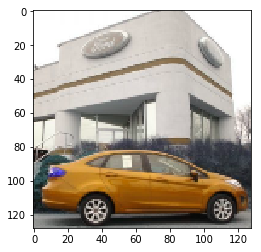

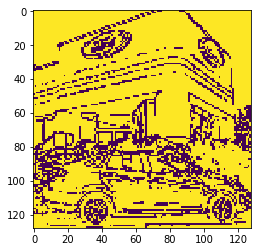

In [76]:
import matplotlib.pyplot as plt
plt.imshow(imgs[346])
plt.show()
plt.imshow(edges[346])
plt.show()

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from keras.models import Model, Sequential
from keras import optimizers 
import keras.backend as K
from keras.utils.generic_utils import Progbar

In [140]:
#Hyperperemeter
BATCHSIZE=64
LEARNING_RATE = 0.0002
TRAINING_RATIO = 1
BETA_1 = 0.0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.9
BN_EPSILON  = 0.00002
SAVE_DIR = 'gen-imgs/'

GENERATE_ROW_NUM = 8
GENERATE_BATCHSIZE = GENERATE_ROW_NUM*GENERATE_ROW_NUM

In [143]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

generator = build_generator()
discriminator = build_discriminator()

Noise_input_for_training_generator = Input(shape=(128,))
Generated_image                    = generator(Noise_input_for_training_generator)
Discriminator_output               = discriminator(Generated_image)
model_for_training_generator       = Model(Noise_input_for_training_generator, Discriminator_output)
print("model_for_training_generator")
discriminator.trainable = False
model_for_training_generator.summary()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_for_training_generator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss=wasserstein_loss)

model_for_training_generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_232 (InputLayer)       (None, 128)               0         
_________________________________________________________________
Generator (Model)            (None, 64, 64, 3)         8546307   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 8911725   
Total params: 17,458,032
Trainable params: 8,541,443
Non-trainable params: 8,916,589
_________________________________________________________________


In [144]:
Real_image                             = Input(shape=(64,64,3))
Noise_input_for_training_discriminator = Input(shape=(128,))
Fake_image                             = generator(Noise_input_for_training_discriminator)
Discriminator_output_for_real          = discriminator(Real_image)
Discriminator_output_for_fake          = discriminator(Fake_image)

model_for_training_discriminator       = Model([Real_image,
                                                Noise_input_for_training_discriminator],
                                               [Discriminator_output_for_real,
                                                Discriminator_output_for_fake])
print("model_for_training_discriminator")
generator.trainable = False
discriminator.trainable = True
model_for_training_discriminator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss=[wasserstein_loss, wasserstein_loss])
model_for_training_discriminator.summary()

model_for_training_discriminator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_234 (InputLayer)          (None, 128)          0                                            
__________________________________________________________________________________________________
input_233 (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
Generator (Model)               (None, 64, 64, 3)    8546307     input_234[0][0]                  
__________________________________________________________________________________________________
Discriminator (Model)           (None, 1)            8911725     input_233[0][0]                  
                                                                 Generator[2

In [145]:
real_y = np.ones((BATCHSIZE, 1), dtype=np.float32)
fake_y = -real_y

In [146]:
X = imgs/255*2-1

In [147]:

test_noise = np.random.randn(GENERATE_BATCHSIZE, 128)
W_loss = []
discriminator_loss = []
generator_loss = []
for epoch in range(EPOCHS):
    np.random.shuffle(X)
    
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X.shape[0] // BATCHSIZE)
    
    print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    
    progress_bar = Progbar(target=int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO)))
    minibatches_size = BATCHSIZE * TRAINING_RATIO
    
    start_time = time()
    for index in range(int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO))):
        progress_bar.update(index)
        discriminator_minibatches = X[index * minibatches_size:(index + 1) * minibatches_size]
        
        for j in range(TRAINING_RATIO):
            image_batch = discriminator_minibatches[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            noise = np.random.randn(BATCHSIZE, 128).astype(np.float32)
            discriminator.trainable = True
            generator.trainable = False
            discriminator_loss.append(model_for_training_discriminator.train_on_batch([image_batch, noise],
                                                                                      [real_y, fake_y]))
        discriminator.trainable = False
        generator.trainable = True
        generator_loss.append(model_for_training_generator.train_on_batch(np.random.randn(BATCHSIZE, 128), real_y))
    
    print('\nepoch time: {}'.format(time()-start_time))
    
    W_real = model_for_training_generator.evaluate(test_noise, real_y)
    print(W_real)
    W_fake = model_for_training_generator.evaluate(test_noise, fake_y)
    print(W_fake)
    W_l = W_real+W_fake
    print('wasserstein_loss: {}'.format(W_l))
    W_loss.append(W_l)
    #Generate image
    generated_image = generator.predict(test_noise)
    generated_image = (generated_image+1)/2
    for i in range(GENERATE_ROW_NUM):
        new = generated_image[i*GENERATE_ROW_NUM:i*GENERATE_ROW_NUM+GENERATE_ROW_NUM].reshape(64*GENERATE_ROW_NUM,64,3)
        if i!=0:
            old = np.concatenate((old,new),axis=1)
        else:
            old = new
    print('plot generated_image')
    plt.imsave('{}/SN_epoch_{}.png'.format(SAVE_DIR, epoch), old)

epoch 1 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 14s
epoch time: 206.66256833076477
64/64 [==============================] - 9s 148ms/step
[[[[1070.6467 1070.6143 1070.6202]
   [1070.6041 1070.6078 1070.595 ]
   [1070.5701 1070.6205 1070.6011]
   ...
   [1070.675  1070.6738 1070.599 ]
   [1070.6033 1070.5864 1070.5645]
   [1070.6263 1070.6943 1070.561 ]]

  [[1070.5598 1070.5845 1070.6304]
   [1070.5625 1070.6494 1070.6315]
   [1070.5731 1070.6246 1070.6097]
   ...
   [1070.6606 1070.6649 1070.6562]
   [1070.6598 1070.6892 1070.5901]
   [1070.6958 1070.6361 1070.5652]]

  [[1070.6255 1070.5764 1070.6904]
   [1070.5769 1070.5562 1070.5693]
   [1070.632  1070.6692 1070.594 ]
   ...
   [1070.5579 1070.6075 1070.5593]
   [1070.6643 1070.5596 1070.6464]
   [1070.634  1070.6152 1070.6223]]]


 [[[1070.6472 1070.643  1070.6855]
   [1070.6833 1070.6772 1070.5669]
   [1070.6571 1070.6133 1070.6306]
   ...
   [1070.5963 1070.5765 1070.6389]
   [1070.6191 1070.69

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 2 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 156.48563194274902
64/64 [==============================] - 3s 42ms/step
[[[[2399.4482 2399.4155 2399.421 ]
   [2399.4058 2399.407  2399.3955]
   [2399.371  2399.4194 2399.4004]
   ...
   [2399.4756 2399.474  2399.4   ]
   [2399.4072 2399.3896 2399.3672]
   [2399.4282 2399.4937 2399.3618]]

  [[2399.3623 2399.385  2399.4316]
   [2399.365  2399.4512 2399.432 ]
   [2399.373  2399.4243 2399.4092]
   ...
   [2399.4614 2399.4648 2399.4556]
   [2399.4624 2399.4922 2399.3936]
   [2399.4966 2399.436  2399.366 ]]

  [[2399.4272 2399.3792 2399.4905]
   [2399.3784 2399.356  2399.3696]
   [2399.4326 2399.4678 2399.3928]
   ...
   [2399.3604 2399.4072 2399.3604]
   [2399.4668 2399.3623 2399.4465]
   [2399.436  2399.415  2399.4219]]]


 [[[2399.4492 2399.4426 2399.484 ]
   [2399.484  2399.477  2399.367 ]
   [2399.4575 2399.4133 2399.4302]
   ...
   [2399.398  2399.3784 2399.439 ]
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 3 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.51947212219238
64/64 [==============================] - 3s 43ms/step
[[[[4827.243  4827.207  4827.212 ]
   [4827.199  4827.198  4827.188 ]
   [4827.166  4827.2114 4827.193 ]
   ...
   [4827.268  4827.2646 4827.1924]
   [4827.203  4827.1816 4827.16  ]
   [4827.2227 4827.283  4827.1543]]

  [[4827.157  4827.1763 4827.223 ]
   [4827.16   4827.242  4827.2227]
   [4827.168  4827.2153 4827.2017]
   ...
   [4827.2554 4827.255  4827.2466]
   [4827.257  4827.2812 4827.1855]
   [4827.291  4827.2266 4827.158 ]]

  [[4827.2217 4827.172  4827.2803]
   [4827.173  4827.148  4827.162 ]
   [4827.227  4827.258  4827.1855]
   ...
   [4827.1553 4827.1987 4827.1533]
   [4827.2617 4827.1553 4827.2383]
   [4827.2305 4827.206  4827.2144]]]


 [[[4827.243  4827.234  4827.275 ]
   [4827.2773 4827.2676 4827.159 ]
   [4827.252  4827.2046 4827.2217]
   ...
   [4827.1934 4827.171  4827.2305]
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 4 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.68329000473022
64/64 [==============================] - 3s 44ms/step
[[[[10744.254  10744.221  10744.226 ]
   [10744.213  10744.211  10744.2   ]
   [10744.176  10744.225  10744.205 ]
   ...
   [10744.283  10744.279  10744.205 ]
   [10744.214  10744.195  10744.171 ]
   [10744.234  10744.299  10744.165 ]]

  [[10744.166  10744.189  10744.236 ]
   [10744.172  10744.256  10744.236 ]
   [10744.179  10744.229  10744.214 ]
   ...
   [10744.269  10744.268  10744.261 ]
   [10744.2705 10744.297  10744.199 ]
   [10744.305  10744.242  10744.17  ]]

  [[10744.232  10744.184  10744.297 ]
   [10744.186  10744.158  10744.173 ]
   [10744.238  10744.272  10744.197 ]
   ...
   [10744.166  10744.211  10744.165 ]
   [10744.275  10744.168  10744.252 ]
   [10744.242  10744.221  10744.228 ]]]


 [[[10744.256  10744.248  10744.289 ]
   [10744.291  10744.283  10744.17  ]
   [10744.264  107

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 5 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 161.05275774002075
64/64 [==============================] - 3s 44ms/step
[[[[9618.793  9618.76   9618.764 ]
   [9618.752  9618.752  9618.742 ]
   [9618.717  9618.764  9618.746 ]
   ...
   [9618.822  9618.817  9618.746 ]
   [9618.754  9618.734  9618.713 ]
   [9618.775  9618.836  9618.706 ]]

  [[9618.707  9618.7295 9618.775 ]
   [9618.714  9618.796  9618.775 ]
   [9618.719  9618.768  9618.754 ]
   ...
   [9618.808  9618.807  9618.801 ]
   [9618.809  9618.834  9618.74  ]
   [9618.842  9618.779  9618.71  ]]

  [[9618.771  9618.725  9618.834 ]
   [9618.727  9618.7    9618.715 ]
   [9618.777  9618.8125 9618.738 ]
   ...
   [9618.707  9618.752  9618.707 ]
   [9618.814  9618.709  9618.791 ]
   [9618.781  9618.762  9618.766 ]]]


 [[[9618.794  9618.787  9618.828 ]
   [9618.83   9618.821  9618.711 ]
   [9618.803  9618.758  9618.775 ]
   ...
   [9618.744  9618.725  9618.785 ]
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 6 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 160.4363408088684
64/64 [==============================] - 3s 44ms/step
[[[[7641.2656 7641.2324 7641.236 ]
   [7641.2236 7641.2246 7641.213 ]
   [7641.188  7641.2363 7641.217 ]
   ...
   [7641.297  7641.291  7641.2188]
   [7641.2256 7641.205  7641.1846]
   [7641.2476 7641.309  7641.177 ]]

  [[7641.179  7641.2    7641.247 ]
   [7641.185  7641.2686 7641.247 ]
   [7641.191  7641.24   7641.2256]
   ...
   [7641.2803 7641.2803 7641.2734]
   [7641.2812 7641.3066 7641.211 ]
   [7641.316  7641.252  7641.1807]]

  [[7641.2446 7641.1953 7641.3066]
   [7641.198  7641.172  7641.1875]
   [7641.25   7641.284  7641.208 ]
   ...
   [7641.1777 7641.2236 7641.179 ]
   [7641.288  7641.18   7641.2646]
   [7641.254  7641.2334 7641.239 ]]]


 [[[7641.2656 7641.2607 7641.3003]
   [7641.3027 7641.295  7641.184 ]
   [7641.2754 7641.229  7641.248 ]
   ...
   [7641.217  7641.1953 7641.256 ]
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 7 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 160.00846219062805
64/64 [==============================] - 3s 43ms/step
[[[[11456.02   11455.988  11455.99  ]
   [11455.979  11455.9795 11455.969 ]
   [11455.943  11455.99   11455.973 ]
   ...
   [11456.051  11456.045  11455.975 ]
   [11455.981  11455.96   11455.94  ]
   [11456.002  11456.0625 11455.932 ]]

  [[11455.935  11455.956  11456.002 ]
   [11455.941  11456.022  11456.002 ]
   [11455.946  11455.994  11455.98  ]
   ...
   [11456.035  11456.035  11456.027 ]
   [11456.036  11456.061  11455.967 ]
   [11456.068  11456.006  11455.9375]]

  [[11455.998  11455.95   11456.061 ]
   [11455.955  11455.928  11455.943 ]
   [11456.004  11456.038  11455.965 ]
   ...
   [11455.934  11455.979  11455.936 ]
   [11456.042  11455.936  11456.019 ]
   [11456.01   11455.988  11455.994 ]]]


 [[[11456.02   11456.016  11456.055 ]
   [11456.057  11456.049  11455.939 ]
   [11456.029  114

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 8 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.83462977409363
64/64 [==============================] - 3s 44ms/step
[[[[5903.7256 5903.6943 5903.698 ]
   [5903.6865 5903.6865 5903.676 ]
   [5903.6494 5903.6973 5903.6797]
   ...
   [5903.759  5903.752  5903.681 ]
   [5903.6904 5903.666  5903.6475]
   [5903.7104 5903.7695 5903.639 ]]

  [[5903.642  5903.663  5903.7075]
   [5903.6475 5903.7285 5903.709 ]
   [5903.6533 5903.7017 5903.6875]
   ...
   [5903.743  5903.742  5903.7344]
   [5903.743  5903.767  5903.673 ]
   [5903.776  5903.713  5903.6436]]

  [[5903.7056 5903.657  5903.7676]
   [5903.662  5903.6353 5903.6494]
   [5903.7114 5903.745  5903.672 ]
   ...
   [5903.6416 5903.6855 5903.642 ]
   [5903.75   5903.644  5903.7256]
   [5903.7163 5903.695  5903.6997]]]


 [[[5903.7275 5903.7227 5903.7627]
   [5903.7637 5903.756  5903.6465]
   [5903.7373 5903.6904 5903.711 ]
   ...
   [5903.6797 5903.657  5903.718 ]
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 9 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.67606592178345
64/64 [==============================] - 3s 45ms/step
[[[[33261.824 33261.793 33261.797]
   [33261.785 33261.785 33261.773]
   [33261.746 33261.797 33261.777]
   ...
   [33261.86  33261.85  33261.777]
   [33261.79  33261.76  33261.746]
   [33261.81  33261.867 33261.734]]

  [[33261.74  33261.76  33261.805]
   [33261.746 33261.824 33261.81 ]
   [33261.75  33261.8   33261.785]
   ...
   [33261.844 33261.84  33261.832]
   [33261.844 33261.867 33261.77 ]
   [33261.875 33261.81  33261.742]]

  [[33261.805 33261.754 33261.867]
   [33261.758 33261.73  33261.746]
   [33261.81  33261.844 33261.77 ]
   ...
   [33261.74  33261.78  33261.74 ]
   [33261.848 33261.742 33261.824]
   [33261.812 33261.793 33261.797]]]


 [[[33261.824 33261.82  33261.86 ]
   [33261.863 33261.855 33261.742]
   [33261.836 33261.79  33261.81 ]
   ...
   [33261.777 33261.754 33261.816]
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 10 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 160.83917903900146
64/64 [==============================] - 3s 44ms/step
[[[[39430.68  39430.65  39430.652]
   [39430.64  39430.64  39430.63 ]
   [39430.6   39430.652 39430.633]
   ...
   [39430.71  39430.707 39430.633]
   [39430.645 39430.617 39430.6  ]
   [39430.66  39430.723 39430.594]]

  [[39430.594 39430.617 39430.66 ]
   [39430.6   39430.68  39430.664]
   [39430.605 39430.656 39430.64 ]
   ...
   [39430.695 39430.695 39430.688]
   [39430.695 39430.72  39430.625]
   [39430.727 39430.664 39430.598]]

  [[39430.66  39430.61  39430.72 ]
   [39430.617 39430.586 39430.6  ]
   [39430.664 39430.7   39430.625]
   ...
   [39430.594 39430.64  39430.594]
   [39430.703 39430.598 39430.68 ]
   [39430.668 39430.65  39430.656]]]


 [[[39430.68  39430.676 39430.72 ]
   [39430.72  39430.71  39430.6  ]
   [39430.688 39430.645 39430.664]
   ...
   [39430.633 39430.61  39430.67 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 11 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 160.2325029373169
64/64 [==============================] - 3s 44ms/step
[[[[87635.81  87635.78  87635.78 ]
   [87635.766 87635.766 87635.766]
   [87635.734 87635.78  87635.766]
   ...
   [87635.84  87635.84  87635.766]
   [87635.78  87635.75  87635.734]
   [87635.8   87635.86  87635.72 ]]

  [[87635.73  87635.75  87635.8  ]
   [87635.734 87635.81  87635.8  ]
   [87635.734 87635.78  87635.766]
   ...
   [87635.83  87635.83  87635.83 ]
   [87635.83  87635.86  87635.766]
   [87635.86  87635.8   87635.734]]

  [[87635.8   87635.75  87635.86 ]
   [87635.75  87635.72  87635.734]
   [87635.8   87635.83  87635.75 ]
   ...
   [87635.73  87635.766 87635.734]
   [87635.836 87635.734 87635.81 ]
   [87635.8   87635.78  87635.78 ]]]


 [[[87635.81  87635.81  87635.84 ]
   [87635.84  87635.84  87635.734]
   [87635.83  87635.78  87635.8  ]
   ...
   [87635.766 87635.75  87635.8  ]
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 12 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 160.66039109230042
64/64 [==============================] - 3s 45ms/step
[[[[51573.56  51573.53  51573.53 ]
   [51573.52  51573.516 51573.508]
   [51573.484 51573.53  51573.51 ]
   ...
   [51573.594 51573.586 51573.516]
   [51573.523 51573.5   51573.484]
   [51573.54  51573.6   51573.473]]

  [[51573.473 51573.496 51573.54 ]
   [51573.484 51573.562 51573.54 ]
   [51573.484 51573.54  51573.523]
   ...
   [51573.58  51573.58  51573.57 ]
   [51573.58  51573.6   51573.508]
   [51573.61  51573.547 51573.477]]

  [[51573.54  51573.492 51573.6  ]
   [51573.496 51573.47  51573.48 ]
   [51573.547 51573.58  51573.508]
   ...
   [51573.477 51573.516 51573.477]
   [51573.586 51573.477 51573.562]
   [51573.547 51573.53  51573.53 ]]]


 [[[51573.562 51573.555 51573.598]
   [51573.598 51573.59  51573.48 ]
   [51573.57  51573.523 51573.547]
   ...
   [51573.516 51573.492 51573.555]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 13 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 160.1685860157013
64/64 [==============================] - 3s 44ms/step
[[[[138610.53 138610.5  138610.5 ]
   [138610.5  138610.5  138610.48]
   [138610.45 138610.5  138610.48]
   ...
   [138610.56 138610.56 138610.48]
   [138610.5  138610.47 138610.45]
   [138610.52 138610.58 138610.45]]

  [[138610.45 138610.47 138610.52]
   [138610.45 138610.53 138610.52]
   [138610.45 138610.52 138610.5 ]
   ...
   [138610.55 138610.55 138610.55]
   [138610.55 138610.58 138610.48]
   [138610.58 138610.52 138610.45]]

  [[138610.52 138610.47 138610.58]
   [138610.47 138610.44 138610.45]
   [138610.52 138610.55 138610.48]
   ...
   [138610.45 138610.5  138610.45]
   [138610.56 138610.45 138610.53]
   [138610.53 138610.5  138610.52]]]


 [[[138610.53 138610.53 138610.58]
   [138610.58 138610.56 138610.45]
   [138610.55 138610.5  138610.52]
   ...
   [138610.48 138610.47 138610.53]
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 14 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.3019540309906
64/64 [==============================] - 3s 43ms/step
[[[[97672.81  97672.78  97672.8  ]
   [97672.78  97672.78  97672.766]
   [97672.734 97672.8   97672.766]
   ...
   [97672.86  97672.84  97672.78 ]
   [97672.78  97672.766 97672.734]
   [97672.8   97672.86  97672.734]]

  [[97672.734 97672.75  97672.8  ]
   [97672.734 97672.83  97672.8  ]
   [97672.75  97672.8   97672.78 ]
   ...
   [97672.84  97672.84  97672.83 ]
   [97672.84  97672.86  97672.766]
   [97672.875 97672.81  97672.734]]

  [[97672.8   97672.75  97672.86 ]
   [97672.75  97672.72  97672.734]
   [97672.8   97672.84  97672.766]
   ...
   [97672.734 97672.78  97672.734]
   [97672.84  97672.734 97672.83 ]
   [97672.81  97672.78  97672.8  ]]]


 [[[97672.83  97672.81  97672.86 ]
   [97672.86  97672.84  97672.734]
   [97672.83  97672.78  97672.8  ]
   ...
   [97672.766 97672.75  97672.81 ]
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 15 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.6905701160431
64/64 [==============================] - 3s 44ms/step
[[[[174213.55 174213.52 174213.52]
   [174213.52 174213.5  174213.5 ]
   [174213.47 174213.52 174213.5 ]
   ...
   [174213.58 174213.58 174213.5 ]
   [174213.52 174213.48 174213.47]
   [174213.53 174213.6  174213.47]]

  [[174213.47 174213.48 174213.53]
   [174213.47 174213.55 174213.53]
   [174213.47 174213.53 174213.52]
   ...
   [174213.56 174213.56 174213.56]
   [174213.56 174213.6  174213.5 ]
   [174213.6  174213.53 174213.47]]

  [[174213.53 174213.48 174213.6 ]
   [174213.48 174213.45 174213.47]
   [174213.53 174213.56 174213.5 ]
   ...
   [174213.47 174213.52 174213.47]
   [174213.58 174213.47 174213.55]
   [174213.53 174213.52 174213.53]]]


 [[[174213.55 174213.55 174213.6 ]
   [174213.6  174213.58 174213.47]
   [174213.56 174213.52 174213.53]
   ...
   [174213.5  174213.48 174213.55]
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 16 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.6187059879303
64/64 [==============================] - 3s 43ms/step
[[[[256919.31 256919.3  256919.3 ]
   [256919.28 256919.28 256919.28]
   [256919.25 256919.3  256919.28]
   ...
   [256919.36 256919.36 256919.28]
   [256919.3  256919.27 256919.25]
   [256919.31 256919.38 256919.25]]

  [[256919.25 256919.27 256919.31]
   [256919.25 256919.33 256919.31]
   [256919.25 256919.31 256919.28]
   ...
   [256919.34 256919.34 256919.34]
   [256919.34 256919.38 256919.28]
   [256919.38 256919.31 256919.25]]

  [[256919.31 256919.25 256919.38]
   [256919.27 256919.23 256919.25]
   [256919.31 256919.34 256919.28]
   ...
   [256919.25 256919.28 256919.25]
   [256919.34 256919.25 256919.33]
   [256919.31 256919.3  256919.31]]]


 [[[256919.33 256919.33 256919.38]
   [256919.38 256919.36 256919.25]
   [256919.34 256919.28 256919.31]
   ...
   [256919.28 256919.25 256919.31]
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 17 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 165.0099687576294
64/64 [==============================] - 3s 47ms/step
[[[[378643.7  378643.7  378643.7 ]
   [378643.66 378643.66 378643.66]
   [378643.62 378643.7  378643.66]
   ...
   [378643.75 378643.72 378643.66]
   [378643.7  378643.66 378643.62]
   [378643.7  378643.75 378643.62]]

  [[378643.62 378643.66 378643.7 ]
   [378643.62 378643.72 378643.7 ]
   [378643.62 378643.7  378643.66]
   ...
   [378643.72 378643.72 378643.72]
   [378643.72 378643.75 378643.66]
   [378643.75 378643.7  378643.62]]

  [[378643.7  378643.62 378643.75]
   [378643.66 378643.62 378643.62]
   [378643.7  378643.72 378643.66]
   ...
   [378643.62 378643.66 378643.62]
   [378643.72 378643.62 378643.72]
   [378643.7  378643.7  378643.7 ]]]


 [[[378643.72 378643.72 378643.75]
   [378643.75 378643.75 378643.62]
   [378643.72 378643.66 378643.7 ]
   ...
   [378643.66 378643.62 378643.7 ]
 

64/64 [==============================] - 3s 41ms/step
[[[[-566832.8  -566832.8  -566832.8 ]
   [-566832.8  -566832.8  -566832.9 ]
   [-566832.9  -566832.8  -566832.8 ]
   ...
   [-566832.75 -566832.75 -566832.8 ]
   [-566832.8  -566832.9  -566832.9 ]
   [-566832.8  -566832.75 -566832.9 ]]

  [[-566832.9  -566832.9  -566832.8 ]
   [-566832.9  -566832.8  -566832.8 ]
   [-566832.9  -566832.8  -566832.8 ]
   ...
   [-566832.75 -566832.75 -566832.8 ]
   [-566832.75 -566832.75 -566832.9 ]
   [-566832.75 -566832.8  -566832.9 ]]

  [[-566832.8  -566832.9  -566832.75]
   [-566832.9  -566832.9  -566832.9 ]
   [-566832.8  -566832.75 -566832.9 ]
   ...
   [-566832.9  -566832.8  -566832.9 ]
   [-566832.75 -566832.9  -566832.8 ]
   [-566832.8  -566832.8  -566832.8 ]]]


 [[[-566832.8  -566832.8  -566832.75]
   [-566832.75 -566832.75 -566832.9 ]
   [-566832.8  -566832.8  -566832.8 ]
   ...
   [-566832.8  -566832.9  -566832.8 ]
   [-566832.8  -566832.75 -566832.8 ]
   [-566832.8  -566832.75 -566832.8 

plot generated_image
epoch 20 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 162.75668096542358
64/64 [==============================] - 3s 44ms/step
[[[[319896.8  319896.8  319896.8 ]
   [319896.8  319896.8  319896.8 ]
   [319896.75 319896.8  319896.8 ]
   ...
   [319896.88 319896.88 319896.8 ]
   [319896.8  319896.8  319896.75]
   [319896.8  319896.88 319896.75]]

  [[319896.75 319896.8  319896.8 ]
   [319896.75 319896.88 319896.8 ]
   [319896.75 319896.8  319896.8 ]
   ...
   [319896.88 319896.88 319896.88]
   [319896.88 319896.88 319896.8 ]
   [319896.88 319896.8  319896.75]]

  [[319896.8  319896.75 319896.88]
   [319896.8  319896.75 319896.75]
   [319896.8  319896.88 319896.8 ]
   ...
   [319896.75 319896.8  319896.75]
   [319896.88 319896.75 319896.88]
   [319896.8  319896.8  319896.8 ]]]


 [[[319896.88 319896.88 319896.88]
   [319896.88 319896.88 319896.75]
   [319896.88 319896.8  319896.8 ]
   ...
   [319896.8  319896.75 319896.8 ]


64/64 [==============================] - 3s 44ms/step
[[[[-529351.25 -529351.25 -529351.25]
   [-529351.3  -529351.3  -529351.3 ]
   [-529351.4  -529351.25 -529351.3 ]
   ...
   [-529351.25 -529351.25 -529351.3 ]
   [-529351.25 -529351.3  -529351.4 ]
   [-529351.25 -529351.25 -529351.4 ]]

  [[-529351.4  -529351.3  -529351.25]
   [-529351.4  -529351.25 -529351.25]
   [-529351.4  -529351.25 -529351.3 ]
   ...
   [-529351.25 -529351.25 -529351.25]
   [-529351.25 -529351.25 -529351.3 ]
   [-529351.25 -529351.25 -529351.4 ]]

  [[-529351.25 -529351.4  -529351.25]
   [-529351.3  -529351.4  -529351.4 ]
   [-529351.25 -529351.25 -529351.3 ]
   ...
   [-529351.4  -529351.3  -529351.4 ]
   [-529351.25 -529351.4  -529351.25]
   [-529351.25 -529351.25 -529351.25]]]


 [[[-529351.25 -529351.25 -529351.25]
   [-529351.25 -529351.25 -529351.4 ]
   [-529351.25 -529351.3  -529351.25]
   ...
   [-529351.3  -529351.4  -529351.25]
   [-529351.25 -529351.25 -529351.25]
   [-529351.25 -529351.25 -529351.25

plot generated_image
epoch 23 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 160.78428602218628
64/64 [==============================] - 3s 45ms/step
[[[[729058.2  729058.2  729058.2 ]
   [729058.2  729058.2  729058.1 ]
   [729058.1  729058.2  729058.2 ]
   ...
   [729058.25 729058.25 729058.2 ]
   [729058.2  729058.1  729058.1 ]
   [729058.2  729058.25 729058.1 ]]

  [[729058.1  729058.1  729058.2 ]
   [729058.1  729058.2  729058.2 ]
   [729058.1  729058.2  729058.2 ]
   ...
   [729058.25 729058.25 729058.25]
   [729058.25 729058.25 729058.1 ]
   [729058.25 729058.2  729058.1 ]]

  [[729058.2  729058.1  729058.25]
   [729058.1  729058.1  729058.1 ]
   [729058.2  729058.25 729058.1 ]
   ...
   [729058.1  729058.2  729058.1 ]
   [729058.25 729058.1  729058.2 ]
   [729058.2  729058.2  729058.2 ]]]


 [[[729058.2  729058.2  729058.25]
   [729058.25 729058.25 729058.1 ]
   [729058.2  729058.2  729058.2 ]
   ...
   [729058.2  729058.1  729058.2 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 25 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 11s
epoch time: 165.60974216461182
64/64 [==============================] - 3s 46ms/step
[[[[1699462.2 1699462.2 1699462.2]
   [1699462.2 1699462.2 1699462.2]
   [1699462.1 1699462.2 1699462.2]
   ...
   [1699462.2 1699462.2 1699462.2]
   [1699462.2 1699462.2 1699462.2]
   [1699462.2 1699462.2 1699462. ]]

  [[1699462.1 1699462.2 1699462.2]
   [1699462.2 1699462.2 1699462.2]
   [1699462.2 1699462.2 1699462.2]
   ...
   [1699462.2 1699462.2 1699462.2]
   [1699462.2 1699462.2 1699462.2]
   [1699462.2 1699462.2 1699462.2]]

  [[1699462.2 1699462.2 1699462.2]
   [1699462.2 1699462.  1699462.2]
   [1699462.2 1699462.2 1699462.2]
   ...
   [1699462.1 1699462.2 1699462.1]
   [1699462.2 1699462.2 1699462.2]
   [1699462.2 1699462.2 1699462.2]]]


 [[[1699462.2 1699462.2 1699462.2]
   [1699462.2 1699462.2 1699462.1]
   [1699462.2 1699462.2 1699462.2]
   ...
   [1699462.2 1699462.2 1699462.2]


plot generated_image
epoch 27 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 163.37714791297913
64/64 [==============================] - 3s 45ms/step
[[[[1472577.  1472577.  1472577. ]
   [1472577.  1472577.  1472577. ]
   [1472577.  1472577.  1472577. ]
   ...
   [1472577.  1472577.  1472577. ]
   [1472577.  1472577.  1472577. ]
   [1472577.  1472577.1 1472577. ]]

  [[1472577.  1472577.  1472577. ]
   [1472577.  1472577.  1472577. ]
   [1472577.  1472577.  1472577. ]
   ...
   [1472577.  1472577.  1472577. ]
   [1472577.  1472577.  1472577. ]
   [1472577.2 1472577.  1472577. ]]

  [[1472577.  1472577.  1472577.1]
   [1472577.  1472577.  1472577. ]
   [1472577.  1472577.  1472577. ]
   ...
   [1472577.  1472577.  1472577. ]
   [1472577.  1472577.  1472577. ]
   [1472577.  1472577.  1472577. ]]]


 [[[1472577.  1472577.  1472577. ]
   [1472577.  1472577.  1472577. ]
   [1472577.  1472577.  1472577. ]
   ...
   [1472577.  1472577.  1472577. ]


plot generated_image
epoch 29 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 163.61298489570618
64/64 [==============================] - 3s 45ms/step
[[[[762557.7  762557.7  762557.7 ]
   [762557.7  762557.7  762557.6 ]
   [762557.6  762557.7  762557.7 ]
   ...
   [762557.75 762557.75 762557.7 ]
   [762557.7  762557.6  762557.6 ]
   [762557.7  762557.75 762557.6 ]]

  [[762557.6  762557.6  762557.7 ]
   [762557.6  762557.7  762557.7 ]
   [762557.6  762557.7  762557.7 ]
   ...
   [762557.75 762557.75 762557.75]
   [762557.75 762557.75 762557.6 ]
   [762557.75 762557.7  762557.6 ]]

  [[762557.7  762557.6  762557.75]
   [762557.6  762557.6  762557.6 ]
   [762557.7  762557.75 762557.6 ]
   ...
   [762557.6  762557.7  762557.6 ]
   [762557.75 762557.6  762557.7 ]
   [762557.7  762557.7  762557.7 ]]]


 [[[762557.7  762557.7  762557.75]
   [762557.75 762557.75 762557.6 ]
   [762557.7  762557.7  762557.7 ]
   ...
   [762557.7  762557.6  762557.7 ]


plot generated_image
epoch 31 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 162.81672072410583
64/64 [==============================] - 3s 46ms/step
[[[[3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]
   ...
   [3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]]

  [[3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]
   ...
   [3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]]

  [[3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]
   ...
   [3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]]]


 [[[3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]
   [3011575.5 3011575.5 3011575.5]
   ...
   [3011575.5 3011575.5 3011575.5]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 33 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 163.2736942768097
64/64 [==============================] - 3s 46ms/step
[[[[2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   ...
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]]

  [[2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   ...
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]]

  [[2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   ...
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]]]


 [[[2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   ...
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]
   [2380402. 2380402. 2380402.]]

 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 34 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 161.0318648815155
64/64 [==============================] - 3s 44ms/step
[[[[2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   ...
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]]

  [[2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   ...
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]]

  [[2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   ...
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]]]


 [[[2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   ...
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]
   [2808833. 2808833. 2808833.]]

 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 35 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 163.21522998809814
64/64 [==============================] - 3s 44ms/step
[[[[3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]
   ...
   [3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]]

  [[3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]
   ...
   [3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]]

  [[3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]
   ...
   [3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]]]


 [[[3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]
   [3620279.5 3620279.5 3620279.5]
   ...
   [3620279.5 3620279.5 3620279.5]


plot generated_image
epoch 37 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 11s
epoch time: 165.37930703163147
64/64 [==============================] - 3s 45ms/step
[[[[7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   ...
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]]

  [[7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   ...
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]]

  [[7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   ...
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]]]


 [[[7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   ...
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]
   [7904202. 7904202. 7904202.]]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 38 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 11s
epoch time: 166.46162271499634
64/64 [==============================] - 3s 44ms/step
[[[[10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]
   ...
   [10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]]

  [[10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]
   ...
   [10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]]

  [[10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]
   ...
   [10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]]]


 [[[10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]
   [10014610. 10014610. 10014610.]
   ...
   [10014610. 10014610. 10014610.]


plot generated_image
epoch 40 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 164.4997911453247
64/64 [==============================] - 3s 45ms/step
[[[[15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]
   ...
   [15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]]

  [[15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]
   ...
   [15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]]

  [[15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]
   ...
   [15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]]]


 [[[15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]
   [15280583. 15280583. 15280583.]
   ...
   [15280583. 15280583. 15280583.]
 

plot generated_image
epoch 42 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 164.0338578224182
64/64 [==============================] - 3s 45ms/step
[[[[10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]
   ...
   [10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]]

  [[10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]
   ...
   [10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]]

  [[10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]
   ...
   [10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]]]


 [[[10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]
   [10512064. 10512064. 10512064.]
   ...
   [10512064. 10512064. 10512064.]
 

plot generated_image
epoch 44 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 11s
epoch time: 167.37800335884094
64/64 [==============================] - 3s 44ms/step
[[[[10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]
   ...
   [10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]]

  [[10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]
   ...
   [10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]]

  [[10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]
   ...
   [10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]]]


 [[[10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]
   [10822747. 10822747. 10822747.]
   ...
   [10822747. 10822747. 10822747.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 45 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 11s
epoch time: 170.66286611557007
64/64 [==============================] - 3s 46ms/step
[[[[34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]
   ...
   [34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]]

  [[34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]
   ...
   [34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]]

  [[34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]
   ...
   [34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]]]


 [[[34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]
   [34190756. 34190756. 34190756.]
   ...
   [34190756. 34190756. 34190756.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 46 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 11s
epoch time: 166.40359592437744
64/64 [==============================] - 3s 44ms/step
[[[[24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]
   ...
   [24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]]

  [[24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]
   ...
   [24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]]

  [[24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]
   ...
   [24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]]]


 [[[24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]
   [24235444. 24235444. 24235444.]
   ...
   [24235444. 24235444. 24235444.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 47 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 160.48551082611084
64/64 [==============================] - 3s 44ms/step
[[[[33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]
   ...
   [33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]]

  [[33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]
   ...
   [33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]]

  [[33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]
   ...
   [33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]]]


 [[[33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]
   [33445770. 33445770. 33445770.]
   ...
   [33445770. 33445770. 33445770.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 48 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.66626906394958
64/64 [==============================] - 3s 44ms/step
[[[[43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]
   ...
   [43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]]

  [[43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]
   ...
   [43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]]

  [[43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]
   ...
   [43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]]]


 [[[43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]
   [43797548. 43797548. 43797548.]
   ...
   [43797548. 43797548. 43797548.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 50 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.18401265144348
64/64 [==============================] - 3s 43ms/step
[[[[38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]
   ...
   [38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]]

  [[38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]
   ...
   [38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]]

  [[38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]
   ...
   [38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]]]


 [[[38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]
   [38100244. 38100244. 38100244.]
   ...
   [38100244. 38100244. 38100244.]


plot generated_image
epoch 52 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 157.59415221214294
64/64 [==============================] - 3s 43ms/step
[[[[64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]
   ...
   [64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]]

  [[64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]
   ...
   [64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]]

  [[64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]
   ...
   [64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]]]


 [[[64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]
   [64301640. 64301640. 64301640.]
   ...
   [64301640. 64301640. 64301640.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 53 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 157.85983800888062
64/64 [==============================] - 3s 43ms/step
[[[[70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]
   ...
   [70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]]

  [[70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]
   ...
   [70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]]

  [[70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]
   ...
   [70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]]]


 [[[70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]
   [70994060. 70994060. 70994060.]
   ...
   [70994060. 70994060. 70994060.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 55 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.8563530445099
64/64 [==============================] - 3s 43ms/step
[[[[1.1446647e+08 1.1446647e+08 1.1446647e+08]
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]
   ...
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]]

  [[1.1446647e+08 1.1446647e+08 1.1446647e+08]
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]
   ...
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]]

  [[1.1446647e+08 1.1446647e+08 1.1446647e+08]
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]
   ...
   [1.1446647e+08 1.1446647e+08 1.1446647e+08]
   [1.1446647e+08 1.1446647e+0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 56 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.3356649875641
64/64 [==============================] - 3s 43ms/step
[[[[70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]
   ...
   [70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]]

  [[70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]
   ...
   [70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]]

  [[70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]
   ...
   [70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]]]


 [[[70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]
   [70832660. 70832660. 70832660.]
   ...
   [70832660. 70832660. 70832660.]
 

plot generated_image
epoch 58 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 163.32962918281555
64/64 [==============================] - 3s 43ms/step
[[[[1.3531878e+08 1.3531878e+08 1.3531878e+08]
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]
   ...
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]]

  [[1.3531878e+08 1.3531878e+08 1.3531878e+08]
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]
   ...
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]]

  [[1.3531878e+08 1.3531878e+08 1.3531878e+08]
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]
   ...
   [1.3531878e+08 1.3531878e+08 1.3531878e+08]
   [1.3531878e+08 1.3531878e+

64/64 [==============================] - 3s 42ms/step
[[[[-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   ...
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]]

  [[-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   ...
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]]

  [[-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   ...
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]]]


 [[[-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   ...
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.]
   [-18231812. -18231812. -18231812.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 60 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.82055592536926
64/64 [==============================] - 3s 45ms/step
[[[[97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]
   ...
   [97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]]

  [[97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]
   ...
   [97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]]

  [[97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]
   ...
   [97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]]]


 [[[97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]
   [97921544. 97921544. 97921544.]
   ...
   [97921544. 97921544. 97921544.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 61 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.336932182312
64/64 [==============================] - 3s 45ms/step
[[[[1.1063659e+08 1.1063659e+08 1.1063659e+08]
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]
   ...
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]]

  [[1.1063659e+08 1.1063659e+08 1.1063659e+08]
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]
   ...
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]]

  [[1.1063659e+08 1.1063659e+08 1.1063659e+08]
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]
   ...
   [1.1063659e+08 1.1063659e+08 1.1063659e+08]
   [1.1063659e+08 1.1063659e+08

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 62 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.6855912208557
64/64 [==============================] - 3s 44ms/step
[[[[1.8359304e+08 1.8359304e+08 1.8359304e+08]
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]
   ...
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]]

  [[1.8359304e+08 1.8359304e+08 1.8359304e+08]
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]
   ...
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]]

  [[1.8359304e+08 1.8359304e+08 1.8359304e+08]
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]
   ...
   [1.8359304e+08 1.8359304e+08 1.8359304e+08]
   [1.8359304e+08 1.8359304e+0

64/64 [==============================] - 3s 42ms/step
[[[[-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   ...
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]]

  [[-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   ...
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]]

  [[-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   ...
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]
   [-1.5645429e+08 -1.5645429e+08 -1.5645429e+08]]]


 [[[-1.5645429e+0

plot generated_image
epoch 65 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.6967339515686
64/64 [==============================] - 3s 44ms/step
[[[[74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]
   ...
   [74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]]

  [[74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]
   ...
   [74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]]

  [[74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]
   ...
   [74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]]]


 [[[74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]
   [74392000. 74392000. 74392000.]
   ...
   [74392000. 74392000. 74392000.]
 

plot generated_image
epoch 67 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.72126936912537
64/64 [==============================] - 3s 44ms/step
[[[[1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.080444e+08]
   ...
   [1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.080444e+08]]

  [[1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.080444e+08]
   ...
   [1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.080444e+08]]

  [[1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.080444e+08]
   ...
   [1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.080444e+08]
   [1.080444e+08 1.080444e+08 1.0

64/64 [==============================] - 3s 42ms/step
[[[[-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   ...
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]]

  [[-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   ...
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]]

  [[-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   ...
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]]]


 [[[-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   ...
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.]]

  [[-6086148. -6086148. -6086148.]
   [-6086148. -6086148. -6086148.

plot generated_image
epoch 70 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.73996806144714
64/64 [==============================] - 3s 44ms/step
[[[[1.5592742e+08 1.5592742e+08 1.5592742e+08]
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]
   ...
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]]

  [[1.5592742e+08 1.5592742e+08 1.5592742e+08]
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]
   ...
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]]

  [[1.5592742e+08 1.5592742e+08 1.5592742e+08]
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]
   ...
   [1.5592742e+08 1.5592742e+08 1.5592742e+08]
   [1.5592742e+08 1.5592742e+

64/64 [==============================] - 3s 42ms/step
[[[[-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   ...
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]]

  [[-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   ...
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]]

  [[-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   ...
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]
   [-6.4684006e+08 -6.4684006e+08 -6.4684006e+08]]]


 [[[-6.4684006e+0

plot generated_image
epoch 73 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.61050605773926
64/64 [==============================] - 3s 44ms/step
[[[[3.8757322e+08 3.8757322e+08 3.8757322e+08]
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]
   ...
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]]

  [[3.8757322e+08 3.8757322e+08 3.8757322e+08]
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]
   ...
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]]

  [[3.8757322e+08 3.8757322e+08 3.8757322e+08]
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]
   ...
   [3.8757322e+08 3.8757322e+08 3.8757322e+08]
   [3.8757322e+08 3.8757322e+

64/64 [==============================] - 3s 44ms/step
[[[[-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   ...
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]]

  [[-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   ...
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]]

  [[-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   ...
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400295e+08 -3.400295e+08]]]


 [[[-3.400295e+08 -3.400295e+08 -3.400295e+08]
   [-3.400295e+08 -3.400

plot generated_image
epoch 76 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.89781403541565
64/64 [==============================] - 3s 43ms/step
[[[[7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.594105e+08]
   ...
   [7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.594105e+08]]

  [[7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.594105e+08]
   ...
   [7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.594105e+08]]

  [[7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.594105e+08]
   ...
   [7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.594105e+08]
   [7.594105e+08 7.594105e+08 7.5

64/64 [==============================] - 3s 41ms/step
[[[[-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   ...
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]]

  [[-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   ...
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]]

  [[-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   ...
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955374e+08 -2.955374e+08]]]


 [[[-2.955374e+08 -2.955374e+08 -2.955374e+08]
   [-2.955374e+08 -2.955

plot generated_image
epoch 79 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.06368589401245
64/64 [==============================] - 3s 42ms/step
[[[[4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]
   ...
   [4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]]

  [[4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]
   ...
   [4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]]

  [[4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]
   ...
   [4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]
   [4.06922e+08 4.06922e+08 4.06922e+08]]]


 [[[4.06922e+08 4.06922e+08 4.06922e+08

64/64 [==============================] - 3s 41ms/step
[[[[-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   ...
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]]

  [[-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   ...
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]]

  [[-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   ...
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200376e+09 -1.200376e+09]]]


 [[[-1.200376e+09 -1.200376e+09 -1.200376e+09]
   [-1.200376e+09 -1.200

plot generated_image
epoch 82 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 157.47445797920227
64/64 [==============================] - 3s 42ms/step
[[[[6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.459399e+08]
   ...
   [6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.459399e+08]]

  [[6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.459399e+08]
   ...
   [6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.459399e+08]]

  [[6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.459399e+08]
   ...
   [6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.459399e+08]
   [6.459399e+08 6.459399e+08 6.4

64/64 [==============================] - 3s 47ms/step
[[[[-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   ...
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]]

  [[-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   ...
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]]

  [[-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   ...
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]
   [-1.1809044e+09 -1.1809044e+09 -1.1809044e+09]]]


 [[[-1.1809044e+0

plot generated_image
epoch 85 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 160.91807198524475
64/64 [==============================] - 3s 43ms/step
[[[[7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.964481e+08]
   ...
   [7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.964481e+08]]

  [[7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.964481e+08]
   ...
   [7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.964481e+08]]

  [[7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.964481e+08]
   ...
   [7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.964481e+08]
   [7.964481e+08 7.964481e+08 7.9

64/64 [==============================] - 3s 42ms/step
[[[[-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   ...
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]]

  [[-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   ...
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]]

  [[-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   ...
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388426e+08 -8.388426e+08]]]


 [[[-8.388426e+08 -8.388426e+08 -8.388426e+08]
   [-8.388426e+08 -8.388

plot generated_image
epoch 88 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 156.85408520698547
64/64 [==============================] - 3s 43ms/step
[[[[6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.131544e+08]
   ...
   [6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.131544e+08]]

  [[6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.131544e+08]
   ...
   [6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.131544e+08]]

  [[6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.131544e+08]
   ...
   [6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.131544e+08]
   [6.131544e+08 6.131544e+08 6.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 89 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 157.0534369945526
64/64 [==============================] - 3s 43ms/step
[[[[1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.802847e+09]
   ...
   [1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.802847e+09]]

  [[1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.802847e+09]
   ...
   [1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.802847e+09]]

  [[1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.802847e+09]
   ...
   [1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.802847e+09]
   [1.802847e+09 1.802847e+09 1.80

64/64 [==============================] - 3s 42ms/step
[[[[-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   ...
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]]

  [[-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   ...
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]]

  [[-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   ...
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212681e+08 -7.212681e+08]]]


 [[[-7.212681e+08 -7.212681e+08 -7.212681e+08]
   [-7.212681e+08 -7.212

plot generated_image
epoch 92 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 157.07588410377502
64/64 [==============================] - 3s 43ms/step
[[[[2.0317537e+09 2.0317537e+09 2.0317537e+09]
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]
   ...
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]]

  [[2.0317537e+09 2.0317537e+09 2.0317537e+09]
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]
   ...
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]]

  [[2.0317537e+09 2.0317537e+09 2.0317537e+09]
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]
   ...
   [2.0317537e+09 2.0317537e+09 2.0317537e+09]
   [2.0317537e+09 2.0317537e+

64/64 [==============================] - 3s 42ms/step
[[[[-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   ...
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]]

  [[-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   ...
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]]

  [[-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   ...
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]
   [-3.0110566e+09 -3.0110566e+09 -3.0110566e+09]]]


 [[[-3.0110566e+0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 95 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.20228123664856
64/64 [==============================] - 3s 44ms/step
[[[[2.1351473e+09 2.1351473e+09 2.1351473e+09]
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]
   ...
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]]

  [[2.1351473e+09 2.1351473e+09 2.1351473e+09]
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]
   ...
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]]

  [[2.1351473e+09 2.1351473e+09 2.1351473e+09]
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]
   ...
   [2.1351473e+09 2.1351473e+09 2.1351473e+09]
   [2.1351473e+09 2.1351473e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 96 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.60115504264832
64/64 [==============================] - 3s 52ms/step
[[[[3.0047752e+09 3.0047752e+09 3.0047752e+09]
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]
   ...
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]]

  [[3.0047752e+09 3.0047752e+09 3.0047752e+09]
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]
   ...
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]]

  [[3.0047752e+09 3.0047752e+09 3.0047752e+09]
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]
   ...
   [3.0047752e+09 3.0047752e+09 3.0047752e+09]
   [3.0047752e+09 3.0047752e+

64/64 [==============================] - 3s 42ms/step
[[[[-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   ...
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]]

  [[-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   ...
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]]

  [[-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   ...
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999702e+08 -6.999702e+08]]]


 [[[-6.999702e+08 -6.999702e+08 -6.999702e+08]
   [-6.999702e+08 -6.999

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 99 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.6193459033966
64/64 [==============================] - 3s 43ms/step
[[[[3.6175997e+09 3.6175997e+09 3.6175997e+09]
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]
   ...
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]]

  [[3.6175997e+09 3.6175997e+09 3.6175997e+09]
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]
   ...
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]]

  [[3.6175997e+09 3.6175997e+09 3.6175997e+09]
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]
   ...
   [3.6175997e+09 3.6175997e+09 3.6175997e+09]
   [3.6175997e+09 3.6175997e+0

64/64 [==============================] - 3s 51ms/step
[[[[-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   ...
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]]

  [[-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   ...
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]]

  [[-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   ...
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]
   [-1.4965216e+09 -1.4965216e+09 -1.4965216e+09]]]


 [[[-1.4965216e+0

plot generated_image
epoch 102 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.14527201652527
64/64 [==============================] - 3s 43ms/step
[[[[5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.141285e+09]
   ...
   [5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.141285e+09]]

  [[5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.141285e+09]
   ...
   [5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.141285e+09]]

  [[5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.141285e+09]
   ...
   [5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.141285e+09]
   [5.141285e+09 5.141285e+09 5.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 103 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 159.2805790901184
64/64 [==============================] - 3s 43ms/step
[[[[5.7136077e+09 5.7136077e+09 5.7136077e+09]
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]
   ...
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]]

  [[5.7136077e+09 5.7136077e+09 5.7136077e+09]
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]
   ...
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]]

  [[5.7136077e+09 5.7136077e+09 5.7136077e+09]
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]
   ...
   [5.7136077e+09 5.7136077e+09 5.7136077e+09]
   [5.7136077e+09 5.7136077e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 104 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.19475603103638
64/64 [==============================] - 3s 43ms/step
[[[[4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.201067e+09]
   ...
   [4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.201067e+09]]

  [[4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.201067e+09]
   ...
   [4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.201067e+09]]

  [[4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.201067e+09]
   ...
   [4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.201067e+09]
   [4.201067e+09 4.201067e+09 4.

64/64 [==============================] - 3s 42ms/step
[[[[-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   ...
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]]

  [[-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   ...
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]]

  [[-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   ...
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]
   [-5.8335867e+09 -5.8335867e+09 -5.8335867e+09]]]


 [[[-5.8335867e+0

plot generated_image
epoch 107 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.29621624946594
64/64 [==============================] - 3s 44ms/step
[[[[3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.840484e+09]
   ...
   [3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.840484e+09]]

  [[3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.840484e+09]
   ...
   [3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.840484e+09]]

  [[3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.840484e+09]
   ...
   [3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.840484e+09]
   [3.840484e+09 3.840484e+09 3.

64/64 [==============================] - 3s 42ms/step
[[[[-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   ...
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]]

  [[-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   ...
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]]

  [[-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   ...
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418629e+09 -7.418629e+09]]]


 [[[-7.418629e+09 -7.418629e+09 -7.418629e+09]
   [-7.418629e+09 -7.418

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 109 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.89969897270203
64/64 [==============================] - 3s 43ms/step
[[[[1.8511247e+09 1.8511247e+09 1.8511247e+09]
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]
   ...
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]]

  [[1.8511247e+09 1.8511247e+09 1.8511247e+09]
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]
   ...
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]]

  [[1.8511247e+09 1.8511247e+09 1.8511247e+09]
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]
   ...
   [1.8511247e+09 1.8511247e+09 1.8511247e+09]
   [1.8511247e+09 1.8511247e

64/64 [==============================] - 3s 42ms/step
[[[[-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   ...
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]]

  [[-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   ...
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]]

  [[-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   ...
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]
   [-6.2600417e+09 -6.2600417e+09 -6.2600417e+09]]]


 [[[-6.2600417e+0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 112 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 158.64680814743042
64/64 [==============================] - 3s 44ms/step
[[[[7.6939397e+09 7.6939397e+09 7.6939397e+09]
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]
   ...
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]]

  [[7.6939397e+09 7.6939397e+09 7.6939397e+09]
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]
   ...
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]]

  [[7.6939397e+09 7.6939397e+09 7.6939397e+09]
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]
   ...
   [7.6939397e+09 7.6939397e+09 7.6939397e+09]
   [7.6939397e+09 7.6939397e

64/64 [==============================] - 3s 41ms/step
[[[[-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   ...
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]]

  [[-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   ...
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]]

  [[-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   ...
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]
   [-5.6117724e+09 -5.6117724e+09 -5.6117724e+09]]]


 [[[-5.6117724e+0

plot generated_image
epoch 115 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 162.31311202049255
64/64 [==============================] - 3s 43ms/step
[[[[8.5597394e+09 8.5597394e+09 8.5597394e+09]
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]
   ...
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]]

  [[8.5597394e+09 8.5597394e+09 8.5597394e+09]
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]
   ...
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]]

  [[8.5597394e+09 8.5597394e+09 8.5597394e+09]
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]
   ...
   [8.5597394e+09 8.5597394e+09 8.5597394e+09]
   [8.5597394e+09 8.5597394e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 116 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 155.4690523147583
64/64 [==============================] - 3s 42ms/step
[[[[3.9689344e+09 3.9689344e+09 3.9689344e+09]
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]
   ...
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]]

  [[3.9689344e+09 3.9689344e+09 3.9689344e+09]
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]
   ...
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]]

  [[3.9689344e+09 3.9689344e+09 3.9689344e+09]
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]
   ...
   [3.9689344e+09 3.9689344e+09 3.9689344e+09]
   [3.9689344e+09 3.9689344e+

64/64 [==============================] - 3s 41ms/step
[[[[-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   ...
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]]

  [[-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   ...
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]]

  [[-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   ...
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879172e+09 -8.879172e+09]]]


 [[[-8.879172e+09 -8.879172e+09 -8.879172e+09]
   [-8.879172e+09 -8.879

plot generated_image
epoch 119 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.10758805274963
64/64 [==============================] - 3s 42ms/step
[[[[2.6981737e+09 2.6981737e+09 2.6981737e+09]
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]
   ...
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]]

  [[2.6981737e+09 2.6981737e+09 2.6981737e+09]
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]
   ...
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]]

  [[2.6981737e+09 2.6981737e+09 2.6981737e+09]
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]
   ...
   [2.6981737e+09 2.6981737e+09 2.6981737e+09]
   [2.6981737e+09 2.6981737e

64/64 [==============================] - 3s 40ms/step
[[[[-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   ...
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]]

  [[-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   ...
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]]

  [[-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   ...
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]
   [-1.1807314e+10 -1.1807314e+10 -1.1807314e+10]]]


 [[[-1.1807314e+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 122 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.47579312324524
64/64 [==============================] - 3s 42ms/step
[[[[1.0651294e+10 1.0651294e+10 1.0651294e+10]
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]
   ...
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]]

  [[1.0651294e+10 1.0651294e+10 1.0651294e+10]
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]
   ...
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]]

  [[1.0651294e+10 1.0651294e+10 1.0651294e+10]
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]
   ...
   [1.0651294e+10 1.0651294e+10 1.0651294e+10]
   [1.0651294e+10 1.0651294e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 123 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.76733422279358
64/64 [==============================] - 3s 43ms/step
[[[[1.0895077e+10 1.0895077e+10 1.0895077e+10]
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]
   ...
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]]

  [[1.0895077e+10 1.0895077e+10 1.0895077e+10]
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]
   ...
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]]

  [[1.0895077e+10 1.0895077e+10 1.0895077e+10]
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]
   ...
   [1.0895077e+10 1.0895077e+10 1.0895077e+10]
   [1.0895077e+10 1.0895077e

64/64 [==============================] - 3s 40ms/step
[[[[-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   ...
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]]

  [[-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   ...
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]]

  [[-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   ...
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435349e+10 -1.435349e+10]]]


 [[[-1.435349e+10 -1.435349e+10 -1.435349e+10]
   [-1.435349e+10 -1.435

plot generated_image
epoch 126 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.59662985801697
64/64 [==============================] - 3s 42ms/step
[[[[1.3372568e+10 1.3372568e+10 1.3372568e+10]
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]
   ...
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]]

  [[1.3372568e+10 1.3372568e+10 1.3372568e+10]
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]
   ...
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]]

  [[1.3372568e+10 1.3372568e+10 1.3372568e+10]
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]
   ...
   [1.3372568e+10 1.3372568e+10 1.3372568e+10]
   [1.3372568e+10 1.3372568e

64/64 [==============================] - 3s 41ms/step
[[[[-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   ...
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]]

  [[-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   ...
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]]

  [[-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   ...
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]
   [-1.4517208e+10 -1.4517208e+10 -1.4517208e+10]]]


 [[[-1.4517208e+1

plot generated_image
epoch 129 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 155.1675410270691
64/64 [==============================] - 3s 43ms/step
[[[[1.4757527e+10 1.4757527e+10 1.4757527e+10]
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]
   ...
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]]

  [[1.4757527e+10 1.4757527e+10 1.4757527e+10]
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]
   ...
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]]

  [[1.4757527e+10 1.4757527e+10 1.4757527e+10]
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]
   ...
   [1.4757527e+10 1.4757527e+10 1.4757527e+10]
   [1.4757527e+10 1.4757527e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 130 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.92497205734253
64/64 [==============================] - 3s 43ms/step
[[[[1.2190585e+10 1.2190585e+10 1.2190585e+10]
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]
   ...
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]]

  [[1.2190585e+10 1.2190585e+10 1.2190585e+10]
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]
   ...
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]]

  [[1.2190585e+10 1.2190585e+10 1.2190585e+10]
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]
   ...
   [1.2190585e+10 1.2190585e+10 1.2190585e+10]
   [1.2190585e+10 1.2190585e

64/64 [==============================] - 3s 40ms/step
[[[[-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   ...
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]]

  [[-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   ...
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]]

  [[-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   ...
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]
   [-1.6885158e+10 -1.6885158e+10 -1.6885158e+10]]]


 [[[-1.6885158e+1

plot generated_image
epoch 133 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.41425013542175
64/64 [==============================] - 3s 42ms/step
[[[[1.3130575e+10 1.3130575e+10 1.3130575e+10]
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]
   ...
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]]

  [[1.3130575e+10 1.3130575e+10 1.3130575e+10]
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]
   ...
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]]

  [[1.3130575e+10 1.3130575e+10 1.3130575e+10]
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]
   ...
   [1.3130575e+10 1.3130575e+10 1.3130575e+10]
   [1.3130575e+10 1.3130575e

64/64 [==============================] - 3s 41ms/step
[[[[-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   ...
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]]

  [[-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   ...
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]]

  [[-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   ...
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077247e+10 -1.077247e+10]]]


 [[[-1.077247e+10 -1.077247e+10 -1.077247e+10]
   [-1.077247e+10 -1.077

plot generated_image
epoch 136 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.05101990699768
64/64 [==============================] - 3s 43ms/step
[[[[1.3488901e+10 1.3488901e+10 1.3488901e+10]
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]
   ...
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]]

  [[1.3488901e+10 1.3488901e+10 1.3488901e+10]
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]
   ...
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]]

  [[1.3488901e+10 1.3488901e+10 1.3488901e+10]
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]
   ...
   [1.3488901e+10 1.3488901e+10 1.3488901e+10]
   [1.3488901e+10 1.3488901e

64/64 [==============================] - 3s 41ms/step
[[[[-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   ...
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]]

  [[-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   ...
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]]

  [[-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   ...
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]
   [-3.1462142e+10 -3.1462142e+10 -3.1462142e+10]]]


 [[[-3.1462142e+1

plot generated_image
epoch 139 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.67267775535583
64/64 [==============================] - 3s 42ms/step
[[[[2.2184993e+10 2.2184993e+10 2.2184993e+10]
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]
   ...
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]]

  [[2.2184993e+10 2.2184993e+10 2.2184993e+10]
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]
   ...
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]]

  [[2.2184993e+10 2.2184993e+10 2.2184993e+10]
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]
   ...
   [2.2184993e+10 2.2184993e+10 2.2184993e+10]
   [2.2184993e+10 2.2184993e

64/64 [==============================] - 3s 41ms/step
[[[[-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   ...
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]]

  [[-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   ...
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]]

  [[-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   ...
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]
   [-1.3580369e+10 -1.3580369e+10 -1.3580369e+10]]]


 [[[-1.3580369e+1

plot generated_image
epoch 142 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.25255393981934
64/64 [==============================] - 3s 44ms/step
[[[[1.3244278e+10 1.3244278e+10 1.3244278e+10]
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]
   ...
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]]

  [[1.3244278e+10 1.3244278e+10 1.3244278e+10]
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]
   ...
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]]

  [[1.3244278e+10 1.3244278e+10 1.3244278e+10]
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]
   ...
   [1.3244278e+10 1.3244278e+10 1.3244278e+10]
   [1.3244278e+10 1.3244278e

64/64 [==============================] - 3s 41ms/step
[[[[-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   ...
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]]

  [[-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   ...
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]]

  [[-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   ...
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]
   [-2.5418322e+10 -2.5418322e+10 -2.5418322e+10]]]


 [[[-2.5418322e+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 145 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 156.81265687942505
64/64 [==============================] - 3s 48ms/step
[[[[1.2517272e+10 1.2517272e+10 1.2517272e+10]
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]
   ...
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]]

  [[1.2517272e+10 1.2517272e+10 1.2517272e+10]
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]
   ...
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]]

  [[1.2517272e+10 1.2517272e+10 1.2517272e+10]
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]
   ...
   [1.2517272e+10 1.2517272e+10 1.2517272e+10]
   [1.2517272e+10 1.2517272e

64/64 [==============================] - 3s 47ms/step
[[[[-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   ...
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]]

  [[-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   ...
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]]

  [[-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   ...
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]
   [-3.6904354e+10 -3.6904354e+10 -3.6904354e+10]]]


 [[[-3.6904354e+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 147 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.73156213760376
64/64 [==============================] - 3s 42ms/step
[[[[3.0394454e+10 3.0394454e+10 3.0394454e+10]
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]
   ...
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]]

  [[3.0394454e+10 3.0394454e+10 3.0394454e+10]
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]
   ...
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]]

  [[3.0394454e+10 3.0394454e+10 3.0394454e+10]
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]
   ...
   [3.0394454e+10 3.0394454e+10 3.0394454e+10]
   [3.0394454e+10 3.0394454e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 148 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.5196361541748
64/64 [==============================] - 3s 42ms/step
[[[[2.4305506e+10 2.4305506e+10 2.4305506e+10]
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]
   ...
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]]

  [[2.4305506e+10 2.4305506e+10 2.4305506e+10]
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]
   ...
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]]

  [[2.4305506e+10 2.4305506e+10 2.4305506e+10]
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]
   ...
   [2.4305506e+10 2.4305506e+10 2.4305506e+10]
   [2.4305506e+10 2.4305506e+

64/64 [==============================] - 3s 41ms/step
[[[[-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   ...
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]]

  [[-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   ...
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]]

  [[-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   ...
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]
   [-3.6061413e+10 -3.6061413e+10 -3.6061413e+10]]]


 [[[-3.6061413e+1

plot generated_image
epoch 151 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 155.0932228565216
64/64 [==============================] - 3s 44ms/step
[[[[4.8936595e+10 4.8936595e+10 4.8936595e+10]
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]
   ...
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]]

  [[4.8936595e+10 4.8936595e+10 4.8936595e+10]
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]
   ...
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]]

  [[4.8936595e+10 4.8936595e+10 4.8936595e+10]
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]
   ...
   [4.8936595e+10 4.8936595e+10 4.8936595e+10]
   [4.8936595e+10 4.8936595e+

64/64 [==============================] - 3s 41ms/step
[[[[-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   ...
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]]

  [[-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   ...
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]]

  [[-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   ...
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]
   [-3.5439685e+09 -3.5439685e+09 -3.5439685e+09]]]


 [[[-3.5439685e+0

plot generated_image
epoch 154 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.28867268562317
64/64 [==============================] - 3s 42ms/step
[[[[1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]
   ...
   [1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]]

  [[1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]
   ...
   [1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]]

  [[1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]
   ...
   [1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]
   [1.87646e+10 1.87646e+10 1.87646e+10]]]


 [[[1.87646e+10 1.87646e+10 1.87646e+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 155 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.32982516288757
64/64 [==============================] - 3s 43ms/step
[[[[3.7979083e+10 3.7979083e+10 3.7979083e+10]
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]
   ...
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]]

  [[3.7979083e+10 3.7979083e+10 3.7979083e+10]
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]
   ...
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]]

  [[3.7979083e+10 3.7979083e+10 3.7979083e+10]
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]
   ...
   [3.7979083e+10 3.7979083e+10 3.7979083e+10]
   [3.7979083e+10 3.7979083e

64/64 [==============================] - 3s 40ms/step
[[[[-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   ...
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]]

  [[-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   ...
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]]

  [[-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   ...
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030751e+10 -4.030751e+10]]]


 [[[-4.030751e+10 -4.030751e+10 -4.030751e+10]
   [-4.030751e+10 -4.030

plot generated_image
epoch 158 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.44772624969482
64/64 [==============================] - 3s 42ms/step
[[[[2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.934752e+10]
   ...
   [2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.934752e+10]]

  [[2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.934752e+10]
   ...
   [2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.934752e+10]]

  [[2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.934752e+10]
   ...
   [2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.934752e+10]
   [2.934752e+10 2.934752e+10 2.

64/64 [==============================] - 3s 40ms/step
[[[[-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   ...
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]]

  [[-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   ...
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]]

  [[-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   ...
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855257e+10 -4.855257e+10]]]


 [[[-4.855257e+10 -4.855257e+10 -4.855257e+10]
   [-4.855257e+10 -4.855

plot generated_image
epoch 161 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.89105105400085
64/64 [==============================] - 3s 42ms/step
[[[[2.8447846e+10 2.8447846e+10 2.8447846e+10]
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]
   ...
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]]

  [[2.8447846e+10 2.8447846e+10 2.8447846e+10]
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]
   ...
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]]

  [[2.8447846e+10 2.8447846e+10 2.8447846e+10]
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]
   ...
   [2.8447846e+10 2.8447846e+10 2.8447846e+10]
   [2.8447846e+10 2.8447846e

64/64 [==============================] - 3s 41ms/step
[[[[-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   ...
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]]

  [[-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   ...
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]]

  [[-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   ...
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]
   [-4.4721975e+10 -4.4721975e+10 -4.4721975e+10]]]


 [[[-4.4721975e+1

plot generated_image
epoch 164 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.77201890945435
64/64 [==============================] - 3s 42ms/step
[[[[5.6716026e+10 5.6716026e+10 5.6716026e+10]
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]
   ...
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]]

  [[5.6716026e+10 5.6716026e+10 5.6716026e+10]
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]
   ...
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]]

  [[5.6716026e+10 5.6716026e+10 5.6716026e+10]
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]
   ...
   [5.6716026e+10 5.6716026e+10 5.6716026e+10]
   [5.6716026e+10 5.6716026e

64/64 [==============================] - 3s 41ms/step
[[[[-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   ...
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]]

  [[-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   ...
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]]

  [[-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   ...
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]
   [-2.6410283e+10 -2.6410283e+10 -2.6410283e+10]]]


 [[[-2.6410283e+1

plot generated_image
epoch 167 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.61732697486877
64/64 [==============================] - 3s 42ms/step
[[[[4.8293052e+10 4.8293052e+10 4.8293052e+10]
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]
   ...
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]]

  [[4.8293052e+10 4.8293052e+10 4.8293052e+10]
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]
   ...
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]]

  [[4.8293052e+10 4.8293052e+10 4.8293052e+10]
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]
   ...
   [4.8293052e+10 4.8293052e+10 4.8293052e+10]
   [4.8293052e+10 4.8293052e

64/64 [==============================] - 3s 41ms/step
[[[[-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   ...
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]]

  [[-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   ...
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]]

  [[-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   ...
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392773e+10 -3.392773e+10]]]


 [[[-3.392773e+10 -3.392773e+10 -3.392773e+10]
   [-3.392773e+10 -3.392

plot generated_image
epoch 170 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.89293718338013
64/64 [==============================] - 3s 43ms/step
[[[[4.4260745e+10 4.4260745e+10 4.4260745e+10]
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]
   ...
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]]

  [[4.4260745e+10 4.4260745e+10 4.4260745e+10]
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]
   ...
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]]

  [[4.4260745e+10 4.4260745e+10 4.4260745e+10]
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]
   ...
   [4.4260745e+10 4.4260745e+10 4.4260745e+10]
   [4.4260745e+10 4.4260745e

64/64 [==============================] - 3s 41ms/step
[[[[-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   ...
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]]

  [[-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   ...
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]]

  [[-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   ...
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805486e+10 -8.805486e+10]]]


 [[[-8.805486e+10 -8.805486e+10 -8.805486e+10]
   [-8.805486e+10 -8.805

plot generated_image
epoch 173 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 155.0023832321167
64/64 [==============================] - 3s 43ms/step
[[[[2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.635475e+10]
   ...
   [2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.635475e+10]]

  [[2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.635475e+10]
   ...
   [2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.635475e+10]]

  [[2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.635475e+10]
   ...
   [2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.635475e+10]
   [2.635475e+10 2.635475e+10 2.6

64/64 [==============================] - 3s 40ms/step
[[[[-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   ...
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]]

  [[-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   ...
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]]

  [[-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   ...
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]
   [-8.4671545e+10 -8.4671545e+10 -8.4671545e+10]]]


 [[[-8.4671545e+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 175 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 155.0788290500641
64/64 [==============================] - 3s 42ms/step
[[[[9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]
   ...
   [9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]]

  [[9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]
   ...
   [9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]]

  [[9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]
   ...
   [9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]
   [9.63796e+10 9.63796e+10 9.63796e+10]]]


 [[[9.63796e+10 9.63796e+10 9.63796e+10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 176 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.53888058662415
64/64 [==============================] - 3s 42ms/step
[[[[5.7192833e+10 5.7192833e+10 5.7192833e+10]
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]
   ...
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]]

  [[5.7192833e+10 5.7192833e+10 5.7192833e+10]
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]
   ...
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]]

  [[5.7192833e+10 5.7192833e+10 5.7192833e+10]
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]
   ...
   [5.7192833e+10 5.7192833e+10 5.7192833e+10]
   [5.7192833e+10 5.7192833e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 177 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.45304608345032
64/64 [==============================] - 3s 43ms/step
[[[[9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.319868e+10]
   ...
   [9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.319868e+10]]

  [[9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.319868e+10]
   ...
   [9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.319868e+10]]

  [[9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.319868e+10]
   ...
   [9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.319868e+10]
   [9.319868e+10 9.319868e+10 9.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 178 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.45950603485107
64/64 [==============================] - 3s 42ms/step
[[[[1.0966016e+11 1.0966016e+11 1.0966016e+11]
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]
   ...
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]]

  [[1.0966016e+11 1.0966016e+11 1.0966016e+11]
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]
   ...
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]]

  [[1.0966016e+11 1.0966016e+11 1.0966016e+11]
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]
   ...
   [1.0966016e+11 1.0966016e+11 1.0966016e+11]
   [1.0966016e+11 1.0966016e

64/64 [==============================] - 3s 41ms/step
[[[[-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   ...
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]]

  [[-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   ...
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]]

  [[-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   ...
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]
   [-1.2616009e+11 -1.2616009e+11 -1.2616009e+11]]]


 [[[-1.2616009e+1

plot generated_image
epoch 181 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.6435739994049
64/64 [==============================] - 3s 43ms/step
[[[[9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.934017e+10]
   ...
   [9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.934017e+10]]

  [[9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.934017e+10]
   ...
   [9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.934017e+10]]

  [[9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.934017e+10]
   ...
   [9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.934017e+10]
   [9.934017e+10 9.934017e+10 9.9

64/64 [==============================] - 3s 41ms/step
[[[[-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   ...
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]]

  [[-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   ...
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]]

  [[-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   ...
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 -1.23279565e+11 -1.23279565e+11]
   [-1.23279565e+11 

plot generated_image
epoch 184 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.43919372558594
64/64 [==============================] - 3s 43ms/step
[[[[1.1828802e+11 1.1828802e+11 1.1828802e+11]
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]
   ...
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]]

  [[1.1828802e+11 1.1828802e+11 1.1828802e+11]
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]
   ...
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]]

  [[1.1828802e+11 1.1828802e+11 1.1828802e+11]
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]
   ...
   [1.1828802e+11 1.1828802e+11 1.1828802e+11]
   [1.1828802e+11 1.1828802e

64/64 [==============================] - 3s 41ms/step
[[[[-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   ...
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]]

  [[-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   ...
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]]

  [[-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   ...
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]
   [-1.0140993e+11 -1.0140993e+11 -1.0140993e+11]]]


 [[[-1.0140993e+1

plot generated_image
epoch 187 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.3156032562256
64/64 [==============================] - 3s 43ms/step
[[[[1.17944254e+11 1.17944254e+11 1.17944254e+11]
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]
   ...
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]]

  [[1.17944254e+11 1.17944254e+11 1.17944254e+11]
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]
   ...
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]]

  [[1.17944254e+11 1.17944254e+11 1.17944254e+11]
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]
   [1.17944254e+11 1.17944254e+11 1.17944254e+11]
   ...
   [1.17944254e+11 1.17944254e+

64/64 [==============================] - 3s 41ms/step
[[[[-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   ...
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]]

  [[-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   ...
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]]

  [[-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   ...
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]
   [-6.3472075e+10 -6.3472075e+10 -6.3472075e+10]]]


 [[[-6.3472075e+1

plot generated_image
epoch 190 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.0303032398224
64/64 [==============================] - 3s 42ms/step
[[[[1.30991915e+11 1.30991915e+11 1.30991915e+11]
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]
   ...
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]]

  [[1.30991915e+11 1.30991915e+11 1.30991915e+11]
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]
   ...
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]]

  [[1.30991915e+11 1.30991915e+11 1.30991915e+11]
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]
   [1.30991915e+11 1.30991915e+11 1.30991915e+11]
   ...
   [1.30991915e+11 1.30991915e+

64/64 [==============================] - 3s 41ms/step
[[[[-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   ...
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]]

  [[-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   ...
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]]

  [[-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   ...
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]
   [-1.2012005e+11 -1.2012005e+11 -1.2012005e+11]]]


 [[[-1.2012005e+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 192 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.49820590019226
64/64 [==============================] - 3s 43ms/step
[[[[9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.826242e+10]
   ...
   [9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.826242e+10]]

  [[9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.826242e+10]
   ...
   [9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.826242e+10]]

  [[9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.826242e+10]
   ...
   [9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.826242e+10]
   [9.826242e+10 9.826242e+10 9.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 193 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 153.7745819091797
64/64 [==============================] - 3s 42ms/step
[[[[7.7679714e+10 7.7679714e+10 7.7679714e+10]
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]
   ...
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]]

  [[7.7679714e+10 7.7679714e+10 7.7679714e+10]
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]
   ...
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]]

  [[7.7679714e+10 7.7679714e+10 7.7679714e+10]
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]
   ...
   [7.7679714e+10 7.7679714e+10 7.7679714e+10]
   [7.7679714e+10 7.7679714e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 194 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.8356111049652
64/64 [==============================] - 3s 42ms/step
[[[[1.3872054e+11 1.3872054e+11 1.3872054e+11]
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]
   ...
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]]

  [[1.3872054e+11 1.3872054e+11 1.3872054e+11]
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]
   ...
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]]

  [[1.3872054e+11 1.3872054e+11 1.3872054e+11]
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]
   ...
   [1.3872054e+11 1.3872054e+11 1.3872054e+11]
   [1.3872054e+11 1.3872054e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 195 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.17340111732483
64/64 [==============================] - 3s 42ms/step
[[[[9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.949276e+10]
   ...
   [9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.949276e+10]]

  [[9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.949276e+10]
   ...
   [9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.949276e+10]]

  [[9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.949276e+10]
   ...
   [9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.949276e+10]
   [9.949276e+10 9.949276e+10 9.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 196 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.85916900634766
64/64 [==============================] - 3s 42ms/step
[[[[1.14656575e+11 1.14656575e+11 1.14656575e+11]
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]
   ...
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]]

  [[1.14656575e+11 1.14656575e+11 1.14656575e+11]
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]
   ...
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]]

  [[1.14656575e+11 1.14656575e+11 1.14656575e+11]
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]
   [1.14656575e+11 1.14656575e+11 1.14656575e+11]
   ...
   [1.14656575e+11 1.14656575e

64/64 [==============================] - 3s 41ms/step
[[[[-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   ...
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]]

  [[-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   ...
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]]

  [[-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   ...
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009933e+10 -8.009933e+10]]]


 [[[-8.009933e+10 -8.009933e+10 -8.009933e+10]
   [-8.009933e+10 -8.009

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 199 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.6832628250122
64/64 [==============================] - 3s 42ms/step
[[[[1.3395385e+11 1.3395385e+11 1.3395385e+11]
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]
   ...
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]]

  [[1.3395385e+11 1.3395385e+11 1.3395385e+11]
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]
   ...
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]]

  [[1.3395385e+11 1.3395385e+11 1.3395385e+11]
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]
   ...
   [1.3395385e+11 1.3395385e+11 1.3395385e+11]
   [1.3395385e+11 1.3395385e+

64/64 [==============================] - 3s 40ms/step
[[[[-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   ...
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]]

  [[-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   ...
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]]

  [[-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   ...
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]
   [-2.0669371e+11 -2.0669371e+11 -2.0669371e+11]]]


 [[[-2.0669371e+1

plot generated_image
epoch 202 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 155.06334614753723
64/64 [==============================] - 3s 42ms/step
[[[[1.9041357e+11 1.9041357e+11 1.9041357e+11]
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]
   ...
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]]

  [[1.9041357e+11 1.9041357e+11 1.9041357e+11]
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]
   ...
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]]

  [[1.9041357e+11 1.9041357e+11 1.9041357e+11]
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]
   ...
   [1.9041357e+11 1.9041357e+11 1.9041357e+11]
   [1.9041357e+11 1.9041357e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 203 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.59027099609375
64/64 [==============================] - 3s 42ms/step
[[[[9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.505925e+10]
   ...
   [9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.505925e+10]]

  [[9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.505925e+10]
   ...
   [9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.505925e+10]]

  [[9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.505925e+10]
   ...
   [9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.505925e+10]
   [9.505925e+10 9.505925e+10 9.

64/64 [==============================] - 3s 41ms/step
[[[[-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   ...
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]]

  [[-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   ...
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]]

  [[-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   ...
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808309e+11 -1.808309e+11]]]


 [[[-1.808309e+11 -1.808309e+11 -1.808309e+11]
   [-1.808309e+11 -1.808

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 206 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 155.09446382522583
64/64 [==============================] - 3s 43ms/step
[[[[1.6684619e+11 1.6684619e+11 1.6684619e+11]
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]
   ...
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]]

  [[1.6684619e+11 1.6684619e+11 1.6684619e+11]
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]
   ...
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]]

  [[1.6684619e+11 1.6684619e+11 1.6684619e+11]
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]
   ...
   [1.6684619e+11 1.6684619e+11 1.6684619e+11]
   [1.6684619e+11 1.6684619e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 207 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 155.1413140296936
64/64 [==============================] - 3s 42ms/step
[[[[2.4994562e+11 2.4994562e+11 2.4994562e+11]
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]
   ...
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]]

  [[2.4994562e+11 2.4994562e+11 2.4994562e+11]
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]
   ...
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]]

  [[2.4994562e+11 2.4994562e+11 2.4994562e+11]
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]
   ...
   [2.4994562e+11 2.4994562e+11 2.4994562e+11]
   [2.4994562e+11 2.4994562e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 208 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.3827531337738
64/64 [==============================] - 3s 42ms/step
[[[[1.2503255e+11 1.2503255e+11 1.2503255e+11]
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]
   ...
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]]

  [[1.2503255e+11 1.2503255e+11 1.2503255e+11]
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]
   ...
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]]

  [[1.2503255e+11 1.2503255e+11 1.2503255e+11]
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]
   ...
   [1.2503255e+11 1.2503255e+11 1.2503255e+11]
   [1.2503255e+11 1.2503255e+

64/64 [==============================] - 3s 41ms/step
[[[[-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   ...
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]]

  [[-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   ...
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]]

  [[-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   ...
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]
   [-1.6623826e+11 -1.6623826e+11 -1.6623826e+11]]]


 [[[-1.6623826e+1

plot generated_image
epoch 211 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 155.25510501861572
64/64 [==============================] - 3s 42ms/step
[[[[1.2364951e+11 1.2364951e+11 1.2364951e+11]
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]
   ...
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]]

  [[1.2364951e+11 1.2364951e+11 1.2364951e+11]
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]
   ...
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]]

  [[1.2364951e+11 1.2364951e+11 1.2364951e+11]
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]
   ...
   [1.2364951e+11 1.2364951e+11 1.2364951e+11]
   [1.2364951e+11 1.2364951e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 212 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.27885007858276
64/64 [==============================] - 3s 43ms/step
[[[[2.4303485e+11 2.4303485e+11 2.4303485e+11]
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]
   ...
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]]

  [[2.4303485e+11 2.4303485e+11 2.4303485e+11]
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]
   ...
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]]

  [[2.4303485e+11 2.4303485e+11 2.4303485e+11]
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]
   ...
   [2.4303485e+11 2.4303485e+11 2.4303485e+11]
   [2.4303485e+11 2.4303485e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 213 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 155.18874192237854
64/64 [==============================] - 3s 41ms/step
[[[[7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.025771e+10]
   ...
   [7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.025771e+10]]

  [[7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.025771e+10]
   ...
   [7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.025771e+10]]

  [[7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.025771e+10]
   ...
   [7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.025771e+10]
   [7.025771e+10 7.025771e+10 7.

64/64 [==============================] - 3s 41ms/step
[[[[-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   ...
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]]

  [[-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   ...
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]]

  [[-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   ...
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444269e+11 -2.444269e+11]]]


 [[[-2.444269e+11 -2.444269e+11 -2.444269e+11]
   [-2.444269e+11 -2.444

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 216 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.51699090003967
64/64 [==============================] - 3s 43ms/step
[[[[3.2969992e+11 3.2969992e+11 3.2969992e+11]
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]
   ...
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]]

  [[3.2969992e+11 3.2969992e+11 3.2969992e+11]
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]
   ...
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]]

  [[3.2969992e+11 3.2969992e+11 3.2969992e+11]
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]
   ...
   [3.2969992e+11 3.2969992e+11 3.2969992e+11]
   [3.2969992e+11 3.2969992e

64/64 [==============================] - 3s 40ms/step
[[[[-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   ...
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]]

  [[-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   ...
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]]

  [[-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   ...
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]
   [-1.5420565e+11 -1.5420565e+11 -1.5420565e+11]]]


 [[[-1.5420565e+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 218 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.2649872303009
64/64 [==============================] - 3s 43ms/step
[[[[2.8880123e+11 2.8880123e+11 2.8880123e+11]
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]
   ...
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]]

  [[2.8880123e+11 2.8880123e+11 2.8880123e+11]
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]
   ...
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]]

  [[2.8880123e+11 2.8880123e+11 2.8880123e+11]
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]
   ...
   [2.8880123e+11 2.8880123e+11 2.8880123e+11]
   [2.8880123e+11 2.8880123e+

64/64 [==============================] - 3s 41ms/step
[[[[-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   ...
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]]

  [[-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   ...
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]]

  [[-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   ...
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384147e+11 -2.384147e+11]]]


 [[[-2.384147e+11 -2.384147e+11 -2.384147e+11]
   [-2.384147e+11 -2.384

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 221 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.47813081741333
64/64 [==============================] - 3s 42ms/step
[[[[2.7748355e+11 2.7748355e+11 2.7748355e+11]
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]
   ...
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]]

  [[2.7748355e+11 2.7748355e+11 2.7748355e+11]
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]
   ...
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]]

  [[2.7748355e+11 2.7748355e+11 2.7748355e+11]
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]
   ...
   [2.7748355e+11 2.7748355e+11 2.7748355e+11]
   [2.7748355e+11 2.7748355e

64/64 [==============================] - 3s 40ms/step
[[[[-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   ...
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]]

  [[-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   ...
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]]

  [[-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   ...
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820088e+11 -3.820088e+11]]]


 [[[-3.820088e+11 -3.820088e+11 -3.820088e+11]
   [-3.820088e+11 -3.820

plot generated_image
epoch 224 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.74782609939575
64/64 [==============================] - 3s 42ms/step
[[[[3.6388677e+11 3.6388677e+11 3.6388677e+11]
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]
   ...
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]]

  [[3.6388677e+11 3.6388677e+11 3.6388677e+11]
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]
   ...
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]]

  [[3.6388677e+11 3.6388677e+11 3.6388677e+11]
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]
   ...
   [3.6388677e+11 3.6388677e+11 3.6388677e+11]
   [3.6388677e+11 3.6388677e

64/64 [==============================] - 3s 41ms/step
[[[[-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   ...
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]]

  [[-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   ...
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]]

  [[-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   ...
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]
   [-2.1693632e+11 -2.1693632e+11 -2.1693632e+11]]]


 [[[-2.1693632e+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 227 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.74583077430725
64/64 [==============================] - 3s 42ms/step
[[[[2.4854397e+11 2.4854397e+11 2.4854397e+11]
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]
   ...
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]]

  [[2.4854397e+11 2.4854397e+11 2.4854397e+11]
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]
   ...
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]]

  [[2.4854397e+11 2.4854397e+11 2.4854397e+11]
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]
   ...
   [2.4854397e+11 2.4854397e+11 2.4854397e+11]
   [2.4854397e+11 2.4854397e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 228 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.87555384635925
64/64 [==============================] - 3s 42ms/step
[[[[2.4007244e+11 2.4007244e+11 2.4007244e+11]
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]
   ...
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]]

  [[2.4007244e+11 2.4007244e+11 2.4007244e+11]
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]
   ...
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]]

  [[2.4007244e+11 2.4007244e+11 2.4007244e+11]
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]
   ...
   [2.4007244e+11 2.4007244e+11 2.4007244e+11]
   [2.4007244e+11 2.4007244e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 229 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.6132309436798
64/64 [==============================] - 3s 43ms/step
[[[[2.1375738e+11 2.1375738e+11 2.1375738e+11]
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]
   ...
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]]

  [[2.1375738e+11 2.1375738e+11 2.1375738e+11]
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]
   ...
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]]

  [[2.1375738e+11 2.1375738e+11 2.1375738e+11]
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]
   ...
   [2.1375738e+11 2.1375738e+11 2.1375738e+11]
   [2.1375738e+11 2.1375738e+

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 230 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.98409795761108
64/64 [==============================] - 3s 42ms/step
[[[[3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.600538e+11]
   ...
   [3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.600538e+11]]

  [[3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.600538e+11]
   ...
   [3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.600538e+11]]

  [[3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.600538e+11]
   ...
   [3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.600538e+11]
   [3.600538e+11 3.600538e+11 3.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 231 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.65184688568115
64/64 [==============================] - 3s 42ms/step
[[[[4.2297626e+11 4.2297626e+11 4.2297626e+11]
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]
   ...
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]]

  [[4.2297626e+11 4.2297626e+11 4.2297626e+11]
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]
   ...
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]]

  [[4.2297626e+11 4.2297626e+11 4.2297626e+11]
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]
   ...
   [4.2297626e+11 4.2297626e+11 4.2297626e+11]
   [4.2297626e+11 4.2297626e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 232 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.40516781806946
64/64 [==============================] - 3s 42ms/step
[[[[6.0831524e+11 6.0831524e+11 6.0831524e+11]
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]
   ...
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]]

  [[6.0831524e+11 6.0831524e+11 6.0831524e+11]
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]
   ...
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]]

  [[6.0831524e+11 6.0831524e+11 6.0831524e+11]
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]
   ...
   [6.0831524e+11 6.0831524e+11 6.0831524e+11]
   [6.0831524e+11 6.0831524e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 233 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.9654779434204
64/64 [==============================] - 3s 43ms/step
[[[[2.7103671e+11 2.7103671e+11 2.7103671e+11]
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]
   ...
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]]

  [[2.7103671e+11 2.7103671e+11 2.7103671e+11]
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]
   ...
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]]

  [[2.7103671e+11 2.7103671e+11 2.7103671e+11]
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]
   ...
   [2.7103671e+11 2.7103671e+11 2.7103671e+11]
   [2.7103671e+11 2.7103671e+

64/64 [==============================] - 3s 41ms/step
[[[[-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   ...
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]]

  [[-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   ...
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]]

  [[-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   ...
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]
   [-3.6405428e+11 -3.6405428e+11 -3.6405428e+11]]]


 [[[-3.6405428e+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 235 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.83019423484802
64/64 [==============================] - 3s 42ms/step
[[[[4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.200317e+11]
   ...
   [4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.200317e+11]]

  [[4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.200317e+11]
   ...
   [4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.200317e+11]]

  [[4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.200317e+11]
   ...
   [4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.200317e+11]
   [4.200317e+11 4.200317e+11 4.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 236 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.8094048500061
64/64 [==============================] - 3s 42ms/step
[[[[4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.193859e+11]
   ...
   [4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.193859e+11]]

  [[4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.193859e+11]
   ...
   [4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.193859e+11]]

  [[4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.193859e+11]
   ...
   [4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.193859e+11]
   [4.193859e+11 4.193859e+11 4.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 237 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 155.22642827033997
64/64 [==============================] - 3s 42ms/step
[[[[3.6153685e+11 3.6153685e+11 3.6153685e+11]
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]
   ...
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]]

  [[3.6153685e+11 3.6153685e+11 3.6153685e+11]
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]
   ...
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]]

  [[3.6153685e+11 3.6153685e+11 3.6153685e+11]
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]
   ...
   [3.6153685e+11 3.6153685e+11 3.6153685e+11]
   [3.6153685e+11 3.6153685e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 238 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.75793981552124
64/64 [==============================] - 3s 42ms/step
[[[[3.7725307e+11 3.7725307e+11 3.7725307e+11]
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]
   ...
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]]

  [[3.7725307e+11 3.7725307e+11 3.7725307e+11]
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]
   ...
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]]

  [[3.7725307e+11 3.7725307e+11 3.7725307e+11]
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]
   ...
   [3.7725307e+11 3.7725307e+11 3.7725307e+11]
   [3.7725307e+11 3.7725307e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 239 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 10s
epoch time: 154.58323407173157
64/64 [==============================] - 3s 42ms/step
[[[[2.3271737e+11 2.3271737e+11 2.3271737e+11]
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]
   ...
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]]

  [[2.3271737e+11 2.3271737e+11 2.3271737e+11]
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]
   ...
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]]

  [[2.3271737e+11 2.3271737e+11 2.3271737e+11]
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]
   ...
   [2.3271737e+11 2.3271737e+11 2.3271737e+11]
   [2.3271737e+11 2.3271737e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 240 of 500
number of batches: 15
14/15 [===========================>..] - ETA: 11s
epoch time: 166.57615303993225
64/64 [==============================] - 3s 44ms/step
[[[[3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.277257e+11]
   ...
   [3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.277257e+11]]

  [[3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.277257e+11]
   ...
   [3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.277257e+11]]

  [[3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.277257e+11]
   ...
   [3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.277257e+11]
   [3.277257e+11 3.277257e+11 3.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plot generated_image
epoch 241 of 500
number of batches: 15
 5/15 [=========>....................] - ETA: 1:52

KeyboardInterrupt: 

In [152]:
gen_img = generator.predict(test_noise)

In [153]:
gen_img = (gen_img +1)/2

In [154]:
gen_img

array([[[[0.8568259 , 0.77873147, 0.7490115 ],
         [0.85222054, 0.7882384 , 0.8131676 ],
         [0.846822  , 0.7554947 , 0.54355377],
         ...,
         [0.92997754, 0.88324034, 0.92553425],
         [0.9221339 , 0.8859236 , 0.8709059 ],
         [0.8447546 , 0.8508223 , 0.86675775]],

        [[0.77683294, 0.71496195, 0.79499555],
         [0.6143031 , 0.76517934, 0.73243475],
         [0.9018154 , 0.8817203 , 0.8182306 ],
         ...,
         [0.9754667 , 0.97314394, 0.98516893],
         [0.9705703 , 0.9692347 , 0.968985  ],
         [0.92441714, 0.8927977 , 0.8763908 ]],

        [[0.667995  , 0.793537  , 0.8577317 ],
         [0.84004986, 0.86460924, 0.8482611 ],
         [0.66421014, 0.6898828 , 0.79323053],
         ...,
         [0.97276604, 0.9887979 , 0.99215627],
         [0.9405527 , 0.9679005 , 0.97065294],
         [0.94424367, 0.9637456 , 0.9563525 ]],

        ...,

        [[0.39122728, 0.3916723 , 0.3942794 ],
         [0.27499598, 0.3531556 , 0.32414132]

In [9]:
plt.imshow(gen_img[7])

NameError: name 'plt' is not defined

In [12]:
import glob
image_fns = sorted(glob.glob("./gen-imgs/*.png"))

In [33]:
import os

for image_name in image_fns:
    split_name = image_name.split('/')
    filename = split_name[-1]
    path = "/".join(split_name[0:2])
    
    split_filename = filename.split('_')[-1]
    corrected_filename = split_filename.rjust(7, '0')
    full_path = "/".join([path, corrected_filename])
    print(full_path)
    os.rename(image_name, full_path)



./gen-imgs/000.png
./gen-imgs/001.png
./gen-imgs/010.png
./gen-imgs/100.png
./gen-imgs/101.png
./gen-imgs/102.png
./gen-imgs/103.png
./gen-imgs/104.png
./gen-imgs/105.png
./gen-imgs/106.png
./gen-imgs/107.png
./gen-imgs/108.png
./gen-imgs/109.png
./gen-imgs/011.png
./gen-imgs/110.png
./gen-imgs/111.png
./gen-imgs/112.png
./gen-imgs/113.png
./gen-imgs/114.png
./gen-imgs/115.png
./gen-imgs/116.png
./gen-imgs/117.png
./gen-imgs/118.png
./gen-imgs/119.png
./gen-imgs/012.png
./gen-imgs/120.png
./gen-imgs/121.png
./gen-imgs/122.png
./gen-imgs/123.png
./gen-imgs/124.png
./gen-imgs/125.png
./gen-imgs/126.png
./gen-imgs/127.png
./gen-imgs/128.png
./gen-imgs/129.png
./gen-imgs/013.png
./gen-imgs/130.png
./gen-imgs/131.png
./gen-imgs/132.png
./gen-imgs/133.png
./gen-imgs/134.png
./gen-imgs/135.png
./gen-imgs/136.png
./gen-imgs/137.png
./gen-imgs/138.png
./gen-imgs/139.png
./gen-imgs/014.png
./gen-imgs/140.png
./gen-imgs/141.png
./gen-imgs/142.png
./gen-imgs/143.png
./gen-imgs/144.png
./gen-imgs/1

In [37]:
filenames = sorted(glob.glob("./gen-imgs/*.png"))

In [38]:
import imageio

In [41]:
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./gen-imgs/first_attempt.gif', images)